# Efficient Hyperspectral Image Classification via Quantization & Low Rank Factorization

# Directory

In [41]:
# ========== 1) Environment, paths, checks ==========
import os, sys, json, math, time, copy, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, cohen_kappa_score, classification_report

# ---- Your paths (Windows) ----
DATA_DIR_PU     = r"D:\Hyperspectral Image Classification\datasets\pu"
DATA_DIR_HYRANK = r"D:\Hyperspectral Image Classification\datasets\HyRANK"
RESULTS_DIR     = r"D:\Hyperspectral Image Classification"

# Required files
PU_U_FILE = "paviaU.mat"
PU_U_GT   = "paviaU_7gt.mat"
PU_C_FILE = "paviaC.mat"
PU_C_GT   = "paviaC_7gt.mat"
L_FILE    = "Loukia.mat"
L_GT      = "Loukia_gt.mat"  # <-- only this (as you asked)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[env] torch={torch.__version__} | device={DEVICE}")

# Quick file checks
def _expect(path):
    ok = os.path.isfile(path)
    print(("✓" if ok else "✗") + " " + path)
    return ok

print("[files] PaviaU/PaviaC:")
_expect(os.path.join(DATA_DIR_PU, PU_U_FILE))
_expect(os.path.join(DATA_DIR_PU, PU_U_GT))
_expect(os.path.join(DATA_DIR_PU, PU_C_FILE))
_expect(os.path.join(DATA_DIR_PU, PU_C_GT))

print("[files] Loukia:")
_have_cube = _expect(os.path.join(DATA_DIR_HYRANK, L_FILE))
_have_gt   = _expect(os.path.join(DATA_DIR_HYRANK, L_GT))
if not _have_cube: print("! Missing Loukia.mat in HyRANK folder.")
if not _have_gt:   print("! Missing Loukia_gt.mat in HyRANK folder.")

os.makedirs(RESULT_DIR, exist_ok=True)

# Small helper: save + show figures
def _save_and_show(fig, out_path, show=True, tight=True):
    if tight: fig.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

[env] torch=2.5.1+cu121 | device=cuda
[files] PaviaU/PaviaC:
✓ D:\Hyperspectral Image Classification\datasets\pu\paviaU.mat
✓ D:\Hyperspectral Image Classification\datasets\pu\paviaU_7gt.mat
✓ D:\Hyperspectral Image Classification\datasets\pu\paviaC.mat
✓ D:\Hyperspectral Image Classification\datasets\pu\paviaC_7gt.mat
[files] Loukia:
✓ D:\Hyperspectral Image Classification\datasets\HyRANK\Loukia.mat
✓ D:\Hyperspectral Image Classification\datasets\HyRANK\Loukia_gt.mat


# load dataset

[load_paviaU] X=(610, 340, 102) y=(610, 340) | bands=102 | uniq labels (head)=[0 1 2 3 4 5 6 7]
[load_paviaC] X=(1096, 715, 102) y=(1096, 715) | bands=102 | uniq labels (head)=[0 1 2 3 4 5 6 7]
[load_loukia] X=(249, 945, 176) y=(249, 945) | bands=176 | uniq labels (head)=[0 1 2 3 4 5 6 7 8 9]


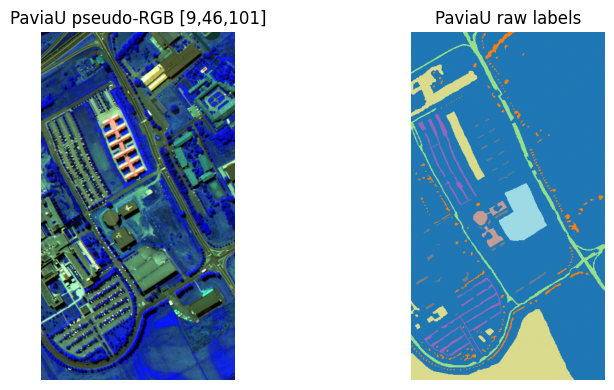

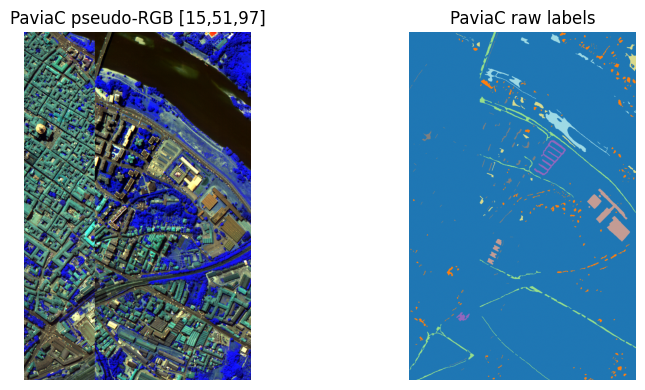

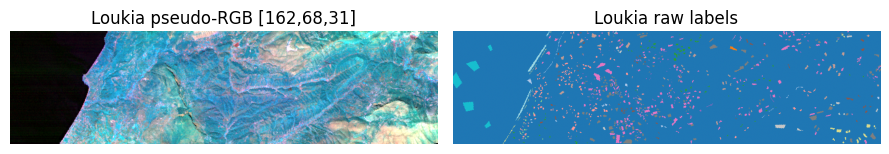

In [42]:
# ========== 2) Raw loaders + quick visual ==========
def _load_mat_any(path):
    d = loadmat(path)
    return {k:v for k,v in d.items() if not k.startswith("__")}

def _pick_cube_and_gt(d_data, d_gt):
    X = next((v for v in d_data.values() if isinstance(v, np.ndarray) and v.ndim == 3), None)
    y = next((v for v in d_gt.values()   if isinstance(v, np.ndarray) and v.ndim == 2), None)
    if X is None or y is None:
        raise ValueError("Could not find a 3D cube or 2D label map in MAT files.")
    X = np.ascontiguousarray(X.astype(np.float32))
    y = np.ascontiguousarray(y.astype(np.int32))
    return X, y

def _sanitize(X, y):
    X = np.asarray(X, dtype=np.float32)
    X[~np.isfinite(X)] = 0.0
    H, W, B = X.shape
    if y.shape[:2] != (H,W):
        if y.T.shape[:2] == (H,W): y = y.T
        else: raise ValueError(f"Label map shape {y.shape} does not match cube {(H,W)}.")
    y[y < 0] = 0   # keep background as 0 if present
    return X, y

def load_paviaU():
    dX = _load_mat_any(os.path.join(DATA_DIR_PU, PU_U_FILE))
    dY = _load_mat_any(os.path.join(DATA_DIR_PU, PU_U_GT))
    X, y = _pick_cube_and_gt(dX, dY)
    X, y = _sanitize(X, y)
    print(f"[load_paviaU] X={X.shape} y={y.shape} | bands={X.shape[2]} | uniq labels (head)={np.unique(y)[:10]}")
    return X, y

def load_paviaC():
    dX = _load_mat_any(os.path.join(DATA_DIR_PU, PU_C_FILE))
    dY = _load_mat_any(os.path.join(DATA_DIR_PU, PU_C_GT))
    X, y = _pick_cube_and_gt(dX, dY)
    X, y = _sanitize(X, y)
    print(f"[load_paviaC] X={X.shape} y={y.shape} | bands={X.shape[2]} | uniq labels (head)={np.unique(y)[:10]}")
    return X, y

def load_loukia():
    dX = _load_mat_any(os.path.join(DATA_DIR_HYRANK, L_FILE))
    dY = _load_mat_any(os.path.join(DATA_DIR_HYRANK, L_GT))
    X, y = _pick_cube_and_gt(dX, dY)
    X, y = _sanitize(X, y)
    print(f"[load_loukia] X={X.shape} y={y.shape} | bands={X.shape[2]} | uniq labels (head)={np.unique(y)[:10]}")
    return X, y

# Load raw cubes (used both by preprocess and cross-dataset prep)
X_u, y_u = load_paviaU()
X_c, y_c = load_paviaC()
X_l, y_l = load_loukia()

# Quick look: pseudo-RGB + labels
def _choose_rgb_bands_by_variance(X):
    var = np.var(X.reshape(-1, X.shape[2]), axis=0)
    order = np.argsort(var)
    idxs = [order[int(len(order)*q)] for q in (0.15, 0.5, 0.85)]
    return tuple(int(i) for i in idxs)

def quick_raw_show(name, X, y, out_dir):
    H,W,B = X.shape
    b1,b2,b3 = _choose_rgb_bands_by_variance(X)
    def norm01(x):
        lo, hi = np.percentile(x, (1,99)); return np.clip((x-lo)/(hi-lo+1e-6), 0, 1)
    vis = np.stack([norm01(X[:,:,b1]), norm01(X[:,:,b2]), norm01(X[:,:,b3])], axis=2)
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    ax[0].imshow(vis); ax[0].set_title(f"{name} pseudo-RGB [{b1},{b2},{b3}]"); ax[0].axis("off")
    ax[1].imshow(y, cmap="tab20"); ax[1].set_title(f"{name} raw labels"); ax[1].axis("off")
    _save_and_show(fig, os.path.join(out_dir, f"{name}_raw_quicklook.png"), show=True)

quick_raw_show("PaviaU", X_u, y_u, os.path.join(RESULTS_DIR, "paviaU"))
quick_raw_show("PaviaC", X_c, y_c, os.path.join(RESULTS_DIR, "paviaC"))
quick_raw_show("Loukia", X_l, y_l, os.path.join(RESULTS_DIR, "loukia"))

# EDA

In [43]:
# === Common helpers (aligned with earlier cells) ===
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reuse the global _save_and_show defined earlier; provide a fallback if missing
if "_save_and_show" not in globals():
    def _save_and_show(fig, out_path, show=True, tight=True):
        if tight:
            fig.tight_layout()
        if out_path:
            os.makedirs(RESULT_DIR, exist_ok=True)
            fig.savefig(out_path, bbox_inches="tight")
        if show:
            plt.show()
        plt.close(fig)

def eda_report(X, y, dataset_name, save_dir, show=True):
    """
    Basic EDA:
      - class counts (json)
      - per-band stats (json)
      - two grayscale band images (png)
      - colored GT with 'tab20' colormap (png)
    Saves artifacts under `save_dir` and shows figures if show=True.
    """
    os.makedirs(RESULT_DIR, exist_ok=True)
    H, W, B = X.shape
    print(f"[{dataset_name}] Cube: {X.shape}, GT: {y.shape}")

    mask = (y > 0)
    if not np.any(mask):
        print(f"[{dataset_name}] WARNING: no labeled pixels (y>0).")
        return

    classes, counts = np.unique(y[mask], return_counts=True)
    print(f"[{dataset_name}] Classes: {classes.tolist()}")
    print(f"[{dataset_name}] Counts : {counts.tolist()}")

    with open(os.path.join(save_dir, "class_counts.json"), "w") as f:
        json.dump({int(c): int(n) for c, n in zip(classes, counts)}, f, indent=2)

    # per-band stats (min/median/max/std over HxW)
    band_min = np.nanmin(X, axis=(0, 1)).tolist()
    band_med = np.nanmedian(X, axis=(0, 1)).tolist()
    band_max = np.nanmax(X, axis=(0, 1)).tolist()
    band_std = np.nanstd(X, axis=(0, 1)).tolist()
    with open(os.path.join(save_dir, "band_stats.json"), "w") as f:
        json.dump(
            {"min": band_min, "median": band_med, "max": band_max, "std": band_std},
            f,
            indent=2,
        )

    # two grayscale bands (band 0 and a later band)
    fig = plt.figure(figsize=(10, 4))
    for i, b in enumerate([0, max(0, min(10, B - 1))]):
        ax = fig.add_subplot(1, 2, i + 1)
        ax.imshow(X[:, :, b], cmap="gray")
        ax.set_title(f"Band {b}")
        ax.axis("off")
    _save_and_show(fig, os.path.join(save_dir, "bands.png"), show=show)

    # colored GT (use same palette style as your quicklook code)
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(y, cmap="tab20")
    ax.set_title("Ground Truth")
    ax.axis("off")
    _save_and_show(fig, os.path.join(save_dir, "gt.png"), show=show)

    # sample spectral profiles (a few per class)
    rng = np.random.default_rng(42)
    profiles = []
    for c in classes[: min(5, len(classes))]:
        rcs = np.argwhere(y == c)
        if rcs.size == 0:
            continue
        take = min(3, rcs.shape[0])
        pick = rcs[rng.choice(rcs.shape[0], size=take, replace=False)]
        for r, cx in pick:
            profiles.append((f"class_{int(c)}", X[r, cx, :]))

    if profiles:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(1, 1, 1)
        for lbl, spec in profiles:
            ax.plot(spec, alpha=0.6, label=lbl)
        ax.legend(ncol=3, fontsize=8)
        ax.set_xlabel("Band")
        ax.set_ylabel("Value")
        ax.set_title("Sample spectral profiles")
        _save_and_show(fig, os.path.join(save_dir, "spectral_profiles.png"), show=show)

    print(f"[{dataset_name}] EDA basic saved -> {save_dir}")

def eda_extras(X, y, save_dir, max_pixels=20000, seed=42, show=True):
    """
    Extras:
      - Band correlation heatmap (downsample bands if >128)
      - PCA cumulative explained variance (up to 64 comps)
    """
    os.makedirs(RESULT_DIR, exist_ok=True)
    rr, cc = np.where(y > 0)
    if rr.size == 0:
        print("[EDA extras] No labeled pixels; skipping.")
        return

    rng = np.random.default_rng(seed)
    take = min(max_pixels, rr.size)
    idx = rng.choice(rr.size, size=take, replace=False)
    samp = X[rr[idx], cc[idx], :]  # (N,B)

    # correlation heatmap (downsample bands if needed)
    B = samp.shape[1]
    step = 1 if B <= 128 else max(1, B // 128)
    corr = np.corrcoef(samp[:, ::step], rowvar=False)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(corr, aspect="auto")
    ax.set_title(f"Band correlation (every {step}th band)")
    fig.colorbar(im, ax=ax)
    _save_and_show(fig, os.path.join(save_dir, "band_correlation.png"), show=show)

    # PCA explained variance (cumulative)
    K = min(64, B)
    pca = PCA(n_components=K, svd_solver="randomized", random_state=seed).fit(samp)
    ev = pca.explained_variance_ratio_

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.cumsum(ev))
    ax.set_xlabel("Components")
    ax.set_ylabel("Cumulative Explained Variance")
    ax.set_title("PCA Scree (cumulative)")
    ax.grid(True, alpha=0.3)
    _save_and_show(fig, os.path.join(save_dir, "pca_scree.png"), show=show)

    print(f"[EDA extras] Saved correlation heatmap + PCA scree -> {save_dir}")

def visualize_results_dir(dir_path, max_json_keys=10):
    """
    Quick viewer: shows PNGs inline and prints first few keys for JSON files.
    Does not modify global paths or settings.
    """
    if not os.path.isdir(dir_path):
        print(f"[visualize] Not a directory: {dir_path}")
        return
    files = sorted(os.listdir(dir_path))
    if not files:
        print(f"[visualize] Directory is empty: {dir_path}")
        return
    print(f"[visualize] Listing -> {dir_path}")
    for fname in files:
        path = os.path.join(dir_path, fname)
        root, ext = os.path.splitext(fname.lower())
        if ext == ".png":
            img = plt.imread(path)
            plt.figure(figsize=(6, 5))
            plt.imshow(img)
            plt.title(fname)
            plt.axis("off")
            plt.show()
        elif ext == ".json":
            try:
                data = json.load(open(path))
                print(f"\n--- {fname} ---")
                if isinstance(data, dict):
                    keys = list(data.keys())
                    for k in keys[:max_json_keys]:
                        print(f"{k}: {data[k]}")
                    if len(keys) > max_json_keys:
                        print(f"... ({len(keys) - max_json_keys} more keys)")
                else:
                    import pprint
                    pprint.pprint(data)
            except Exception as e:
                print(f"[visualize] Could not parse JSON {fname}: {e}")
        else:
            print(f"[visualize] (skipped) {fname}")

[PaviaU] Cube: (610, 340, 102), GT: (610, 340)
[PaviaU] Classes: [1, 2, 3, 4, 5, 6, 7]
[PaviaU] Counts : [3064, 6631, 3682, 1330, 947, 18649, 5029]


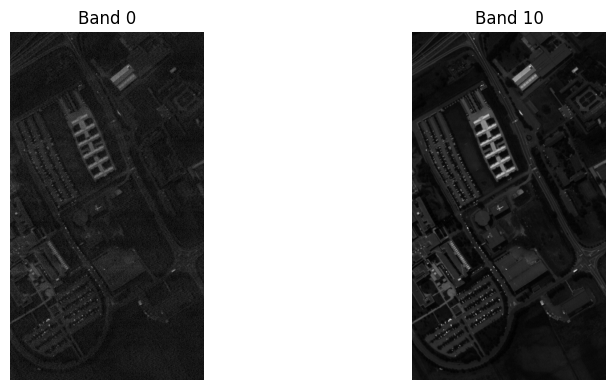

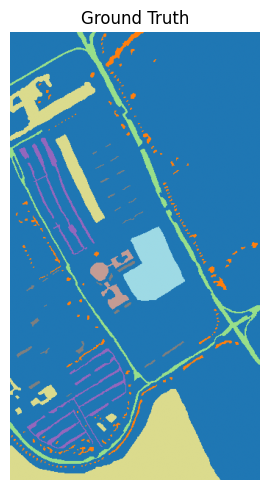

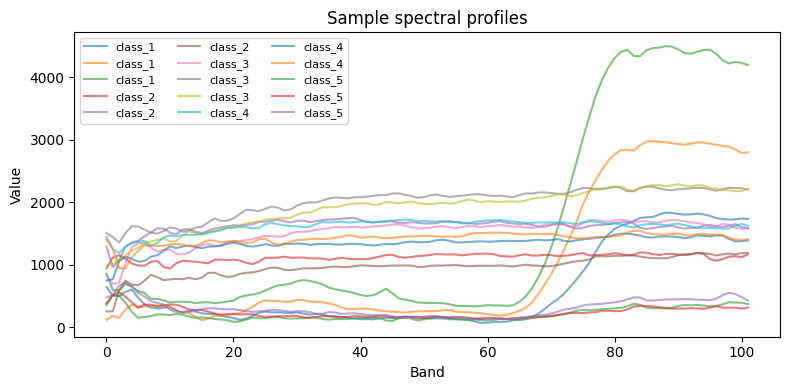

[PaviaU] EDA basic saved -> D:\Hyperspectral Image Classification\paviaU


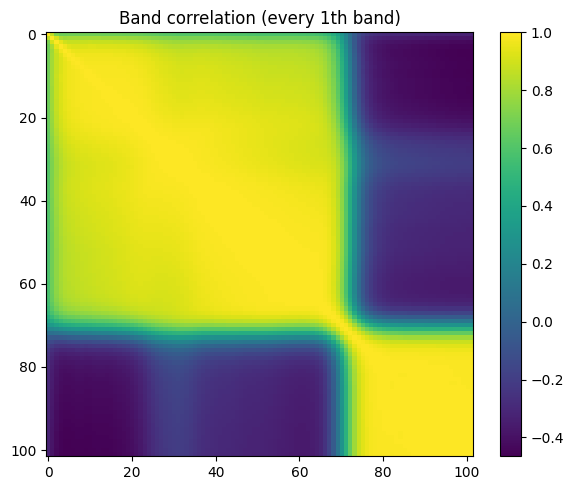

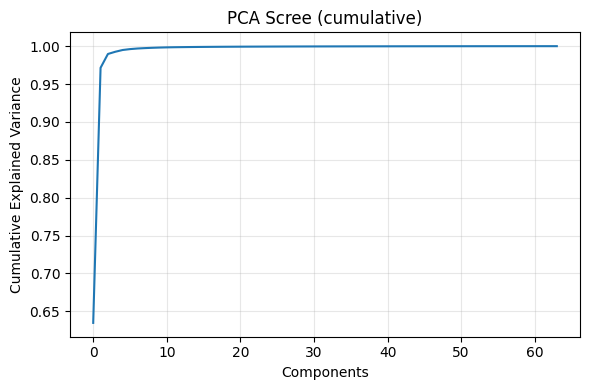

[EDA extras] Saved correlation heatmap + PCA scree -> D:\Hyperspectral Image Classification\paviaU
[PaviaC] Cube: (1096, 715, 102), GT: (1096, 715)
[PaviaC] Classes: [1, 2, 3, 4, 5, 6, 7]
[PaviaC] Counts : [7598, 9248, 2685, 7287, 2863, 3090, 6584]


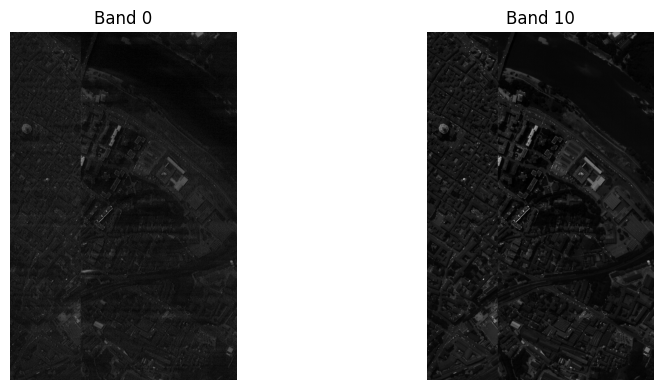

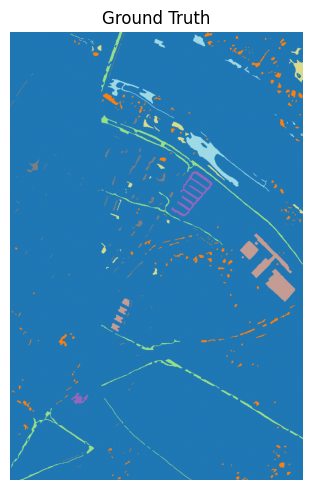

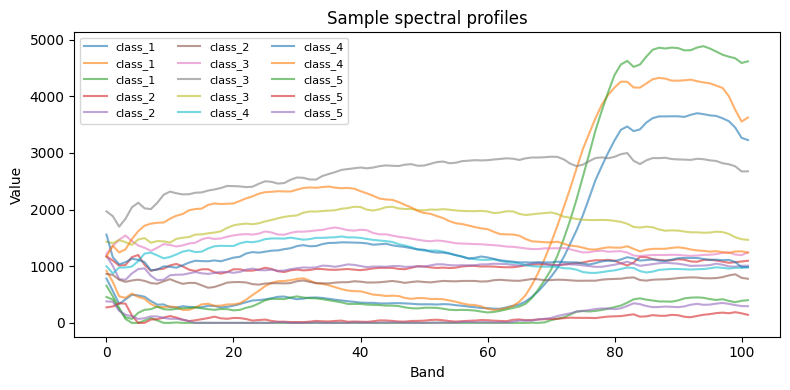

[PaviaC] EDA basic saved -> D:\Hyperspectral Image Classification\paviaC


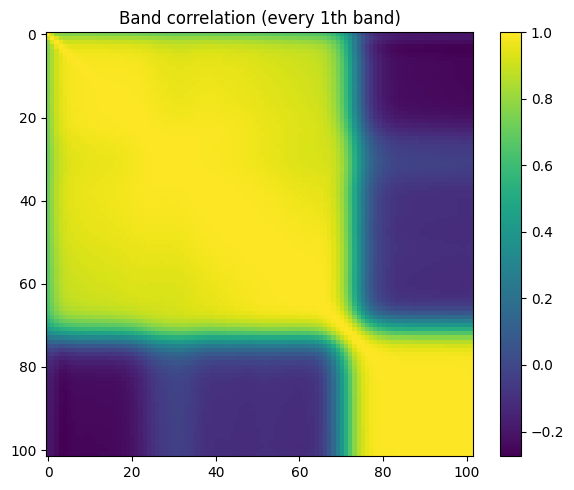

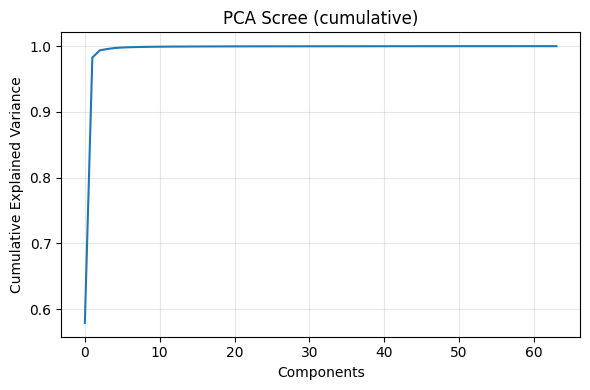

[EDA extras] Saved correlation heatmap + PCA scree -> D:\Hyperspectral Image Classification\paviaC
[Loukia] Cube: (249, 945, 176), GT: (249, 945)
[Loukia] Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[Loukia] Counts : [288, 67, 542, 79, 1401, 223, 500, 1072, 3793, 2803, 404, 487, 1393, 451]


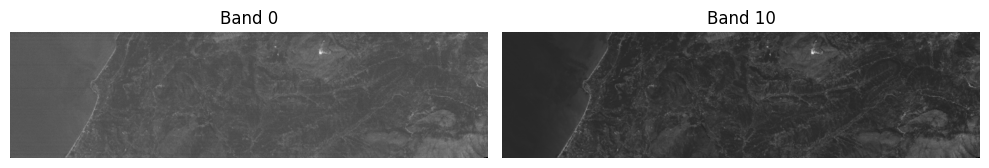

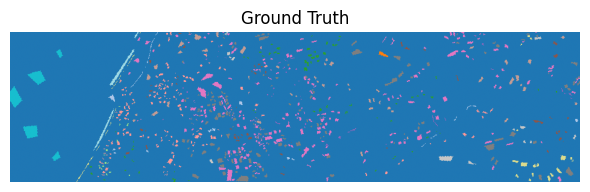

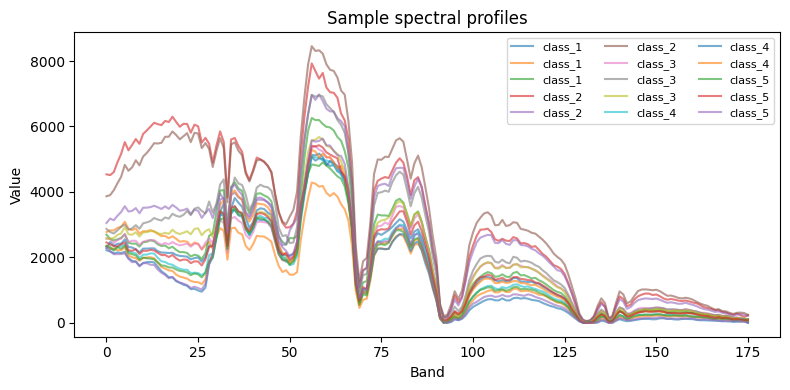

[Loukia] EDA basic saved -> D:\Hyperspectral Image Classification\loukia


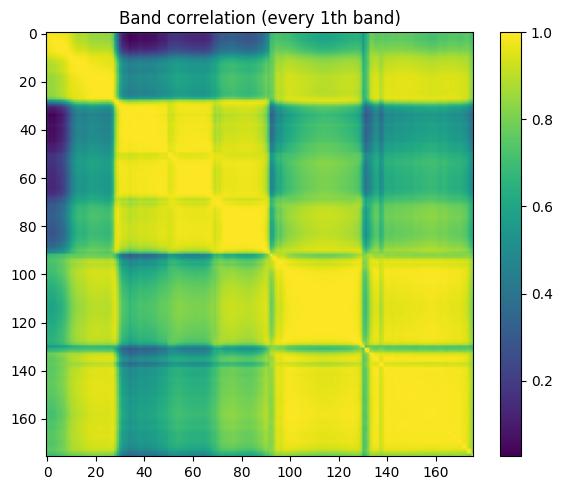

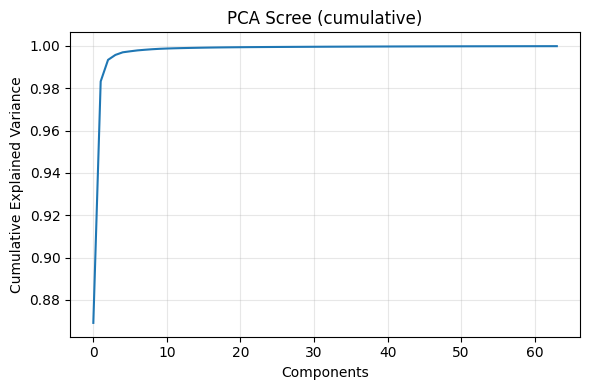

[EDA extras] Saved correlation heatmap + PCA scree -> D:\Hyperspectral Image Classification\loukia


In [44]:
# Example usage
eda_report(X_u, y_u, "PaviaU", os.path.join(RESULTS_DIR, "paviaU"), show=True)
eda_extras(X_u, y_u, os.path.join(RESULTS_DIR, "paviaU"), show=True)

eda_report(X_c, y_c, "PaviaC", os.path.join(RESULTS_DIR, "paviaC"), show=True)
eda_extras(X_c, y_c, os.path.join(RESULTS_DIR, "paviaC"), show=True)

eda_report(X_l, y_l, "Loukia", os.path.join(RESULTS_DIR, "loukia"), show=True)
eda_extras(X_l, y_l, os.path.join(RESULTS_DIR, "loukia"), show=True)

# Preprocesses
    """
    Preprocess with optional hygiene/balancing:
      - sanitize values (+ optional clipping)
      - optionally drop dead bands by std threshold
      - remap labels to 0..C-1 (foreground), background -> -1 in working map
      - stratified split on labeled pixels (includes class 0 correctly)
      - optional class balancing per split
      - extract patches
      - optional per-split dedup via PCA-hash
      - normalize (z-score or robust) using TRAIN only
      - save arrays + metadata (+ inline preview figs)
    """

[load_paviaU] X=(610, 340, 102) y=(610, 340) | bands=102 | uniq labels (head)=[0 1 2 3 4 5 6 7]
[load_paviaC] X=(1096, 715, 102) y=(1096, 715) | bands=102 | uniq labels (head)=[0 1 2 3 4 5 6 7]
[load_loukia] X=(249, 945, 176) y=(249, 945) | bands=176 | uniq labels (head)=[0 1 2 3 4 5 6 7 8 9]

Running preprocess: PaviaU

[paviaU] Start preprocess | X=(610, 340, 102) y=(610, 340) k=9 splits=(0.6, 0.2, 0.2)
[paviaU] Step 1/7: remap labels to zero-based ...
[paviaU]   classes (zero-based): [0, 1, 2, 3, 4, 5, 6]  (orig→zb: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6})


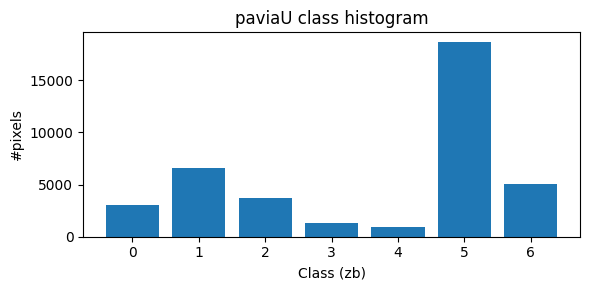

[paviaU] Step 2/7: stratified split (train/val/test) ...
[paviaU]   train N=23599  val N=7866  test N=7867
[paviaU] Balancing splits with {'max_per_class': 8000} ...
[paviaU]   after balance: train N=20410  val N=7866  test N=7867
[paviaU] Step 3/7: extract 9x9 patches ...


Extracting patches: 100%|███████████████████████████████████████████████████████| 7867/7867 [00:00<00:00, 37910.34it/s]


[paviaU]   ptr=(20410, 9, 9, 102) pva=(7866, 9, 9, 102) pte=(7867, 9, 9, 102)


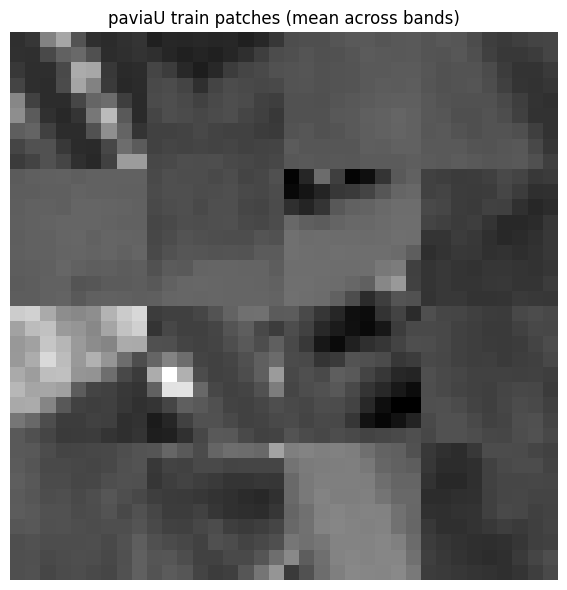

[paviaU] Step 5/7: fit normalization (train only) ...
[paviaU]   z-score stats shapes: mu (102,), std (102,)
[paviaU] Step 6/7: save arrays + metadata → D:\Hyperspectral Image Classification\paviaU\preprocessed
[paviaU] Saved files:
   - paviaU_class_hist.png
   - paviaU_coords.npz
   - paviaU_meta.json
   - paviaU_norm.json
   - paviaU_patch_preview.png
   - paviaU_patches.npz
[paviaU] Step 7/7: done in 127.0s

Running preprocess: PaviaC

[paviaC] Start preprocess | X=(1096, 715, 102) y=(1096, 715) k=9 splits=(0.6, 0.2, 0.2)
[paviaC] Step 1/7: remap labels to zero-based ...
[paviaC]   classes (zero-based): [0, 1, 2, 3, 4, 5, 6]  (orig→zb: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6})


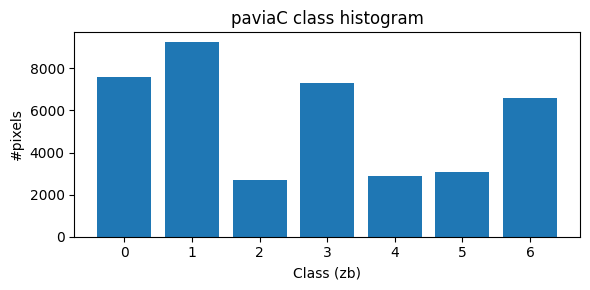

[paviaC] Step 2/7: stratified split (train/val/test) ...
[paviaC]   train N=23613  val N=7871  test N=7871
[paviaC] Balancing splits with {'max_per_class': 8000} ...
[paviaC]   after balance: train N=23613  val N=7871  test N=7871
[paviaC] Step 3/7: extract 9x9 patches ...


Extracting patches: 100%|███████████████████████████████████████████████████████| 7871/7871 [00:00<00:00, 33073.63it/s]


[paviaC]   ptr=(23613, 9, 9, 102) pva=(7871, 9, 9, 102) pte=(7871, 9, 9, 102)


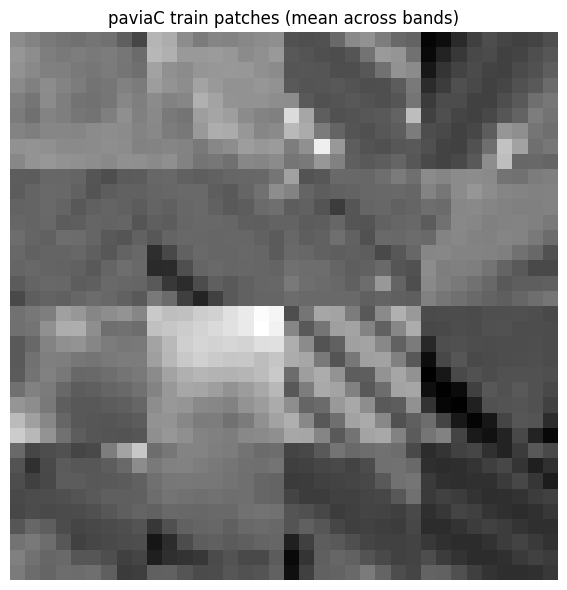

[paviaC] Step 5/7: fit normalization (train only) ...
[paviaC]   z-score stats shapes: mu (102,), std (102,)
[paviaC] Step 6/7: save arrays + metadata → D:\Hyperspectral Image Classification\paviaC\preprocessed
[paviaC] Saved files:
   - paviaC_class_hist.png
   - paviaC_coords.npz
   - paviaC_meta.json
   - paviaC_norm.json
   - paviaC_patch_preview.png
   - paviaC_patches.npz
[paviaC] Step 7/7: done in 148.6s

Running preprocess: Loukia

[loukia] Start preprocess | X=(249, 945, 176) y=(249, 945) k=7 splits=(0.6, 0.2, 0.2)
[loukia] Step 1/7: remap labels to zero-based ...
[loukia]   classes (zero-based): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  (orig→zb: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13})


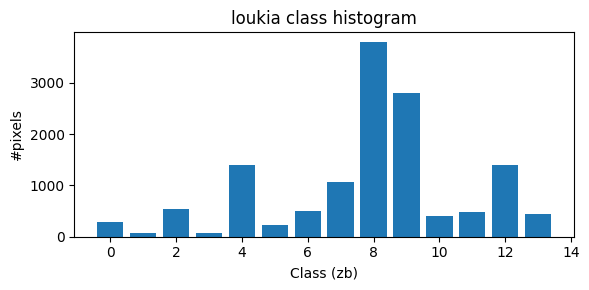

[loukia] Step 2/7: stratified split (train/val/test) ...
[loukia]   train N=8101  val N=2701  test N=2701
[loukia] Balancing splits with {'max_per_class': 6000} ...
[loukia]   after balance: train N=8101  val N=2701  test N=2701
[loukia] Step 3/7: extract 7x7 patches ...


Extracting patches: 100%|███████████████████████████████████████████████████████| 2701/2701 [00:00<00:00, 37108.98it/s]


[loukia]   ptr=(8101, 7, 7, 176) pva=(2701, 7, 7, 176) pte=(2701, 7, 7, 176)


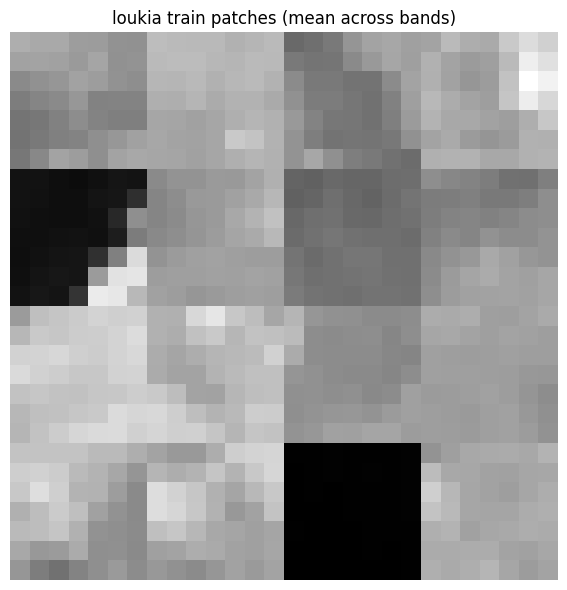

[loukia] Step 5/7: fit normalization (train only) ...
[loukia]   z-score stats shapes: mu (176,), std (176,)
[loukia] Step 6/7: save arrays + metadata → D:\Hyperspectral Image Classification\loukia\preprocessed
[loukia] Saved files:
   - loukia_class_hist.png
   - loukia_coords.npz
   - loukia_meta.json
   - loukia_norm.json
   - loukia_patch_preview.png
   - loukia_patches.npz
[loukia] Step 7/7: done in 47.0s
[paviaU] train (20410, 9, 9, 102) | val (7866, 9, 9, 102) | test (7867, 9, 9, 102) | bands=102
[paviaC] train (23613, 9, 9, 102) | val (7871, 9, 9, 102) | test (7871, 9, 9, 102) | bands=102
[loukia] train (8101, 7, 7, 176) | val (2701, 7, 7, 176) | test (2701, 7, 7, 176) | bands=176


In [45]:
# =========================
# Preprocess U, C, L (enhanced, prints + inline show + saves)
# =========================
import os, time, math, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit

# tqdm (safe fallback)
try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False
    def tqdm(x, **kwargs): return x

# =========================
# Utilities
# =========================
def set_seed(seed=42):
    try:
        import random, torch
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    except Exception:
        np.random.seed(seed)

def _save_and_show(fig, out_path, show=True, tight=True):
    if tight: fig.tight_layout()
    os.makedirs(RESULT_DIR, exist_ok=True)
    fig.savefig(out_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

def visualize_results_dir(dir_path, max_json_keys=10):
    if not os.path.isdir(dir_path):
        print(f"[visualize] Not a directory: {dir_path}")
        return
    files = sorted(os.listdir(dir_path))
    if not files:
        print(f"[visualize] Directory is empty: {dir_path}")
        return
    print(f"[visualize] Listing -> {dir_path}")
    for fname in files:
        path = os.path.join(dir_path, fname)
        root, ext = os.path.splitext(fname.lower())
        if ext == ".png":
            img = plt.imread(path)
            plt.figure(figsize=(6,5))
            plt.imshow(img); plt.title(fname); plt.axis("off")
            plt.show()
        elif ext == ".json":
            try:
                data = json.load(open(path))
                print(f"\n--- {fname} ---")
                if isinstance(data, dict):
                    keys = list(data.keys())
                    for k in keys[:max_json_keys]:
                        print(f"{k}: {data[k]}")
                    if len(keys) > max_json_keys:
                        print(f"... ({len(keys)-max_json_keys} more keys)")
                else:
                    import pprint; pprint.pprint(data)
            except Exception as e:
                print(f"[visualize] Could not parse JSON {fname}: {e}")
        else:
            print(f"[visualize] (skipped) {fname}")

# =========================
# Hygiene & balancing helpers
# =========================
def sanitize_cube(X, clip_percentiles=None):
    """Replace NaN/Inf; optional per-band clipping by percentiles."""
    X = np.asarray(X, dtype=np.float32)
    bad = ~np.isfinite(X)
    if bad.any(): X[bad] = 0.0
    if clip_percentiles:
        p_lo, p_hi = clip_percentiles
        lo = np.nanpercentile(X, p_lo, axis=(0,1), keepdims=True)
        hi = np.nanpercentile(X, p_hi, axis=(0,1), keepdims=True)
        X = np.clip(X, lo, hi)
    return X

def drop_dead_bands(X, std_thresh=1e-8):
    """Drop bands with near-zero std across the image."""
    stds = np.nanstd(X, axis=(0,1))
    keep = stds > std_thresh
    return X[:,:,keep], keep, np.where(~keep)[0].tolist()

def fit_robust(train_patches):
    """Median/MAD stats per band (robust alternative to z-score)."""
    flat = train_patches.reshape(-1, train_patches.shape[-1])
    med = np.median(flat, axis=0)
    mad = np.median(np.abs(flat - med), axis=0) + 1e-6
    return med.astype(np.float32), mad.astype(np.float32)

def apply_robust(patches, med, mad):
    return (patches - med.reshape(1,1,1,-1)) / mad.reshape(1,1,1,-1)

def balance_coords(coords, labels, max_per_class=None, min_per_class=None, seed=42):
    """Down/upsample coords per class within a split; returns shuffled."""
    rng = np.random.default_rng(seed)
    classes = np.unique(labels)
    coords_bal, labels_bal = [], []
    for c in classes:
        idx = np.where(labels==c)[0]
        if len(idx)==0: continue
        if max_per_class is not None and len(idx) > max_per_class:
            idx = rng.choice(idx, size=max_per_class, replace=False)
        if min_per_class is not None and len(idx) < min_per_class:
            extra = rng.choice(idx, size=min_per_class - len(idx), replace=True)
            idx = np.concatenate([idx, extra])
        coords_bal.append(coords[idx]); labels_bal.append(labels[idx])
    if not coords_bal: return coords, labels
    coords_bal = np.concatenate(coords_bal, axis=0)
    labels_bal = np.concatenate(labels_bal, axis=0)
    p = rng.permutation(len(labels_bal))
    return coords_bal[p], labels_bal[p]

def dedup_patches(patches, labels, k_keep=64, tol=1e-5, max_samples=20000, seed=42):
    """
    Approx de-dup: PCA -> round -> hash rows, keep first occurrence.
    Runs per split after patch extraction.
    """
    rng = np.random.default_rng(seed)
    N = patches.shape[0]
    flat = patches.reshape(N, -1)
    take = min(N, max_samples)
    idx = rng.choice(N, size=take, replace=False)
    pca = PCA(n_components=min(k_keep, flat.shape[1]), svd_solver="randomized", random_state=seed).fit(flat[idx])
    Z = pca.transform(flat)
    Zr = np.round(Z / tol).astype(np.int64)
    keys = [Zr[i].tobytes() for i in range(N)]
    first, keep_idx = {}, []
    for i, key in enumerate(keys):
        if key not in first:
            first[key] = i; keep_idx.append(i)
    keep_idx = np.array(keep_idx, dtype=np.int64)
    return patches[keep_idx], labels[keep_idx], keep_idx

# =========================
# Core helpers (patched)
# =========================
def remap_labels_to_zero_based(y):
    """
    Map foreground labels (>0) to 0..C-1, keep background (0) as 0 in the returned map.
    We'll create a working copy where background is -1 so class '0' (a real class) isn't lost.
    """
    mask = y > 0
    classes = np.unique(y[mask])
    mapping = {int(c): int(i) for i, c in enumerate(classes)}
    y2 = y.copy()
    if np.any(mask): y2[mask] = np.vectorize(mapping.get)(y[mask])
    return y2, mapping

def make_pixel_index_list(y_work):
    """
    Build coords & labels from a 'working' label map where:
      - foreground classes are 0..C-1
      - background is marked as -1
    """
    coords = np.argwhere(y_work >= 0)   # include class 0
    labels = y_work[coords[:,0], coords[:,1]]
    return coords, labels

def stratified_split(coords, labels, train_size=0.6, val_size=0.2, test_size=0.2, seed=42):
    assert abs(train_size+val_size+test_size - 1.0) < 1e-6
    s1 = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    tr_idx, rest_idx = next(s1.split(coords, labels))
    coords_tr, labels_tr = coords[tr_idx], labels[tr_idx]
    coords_rest, labels_rest = coords[rest_idx], labels[rest_idx]
    val_ratio = val_size/(val_size+test_size)
    s2 = StratifiedShuffleSplit(n_splits=1, train_size=val_ratio, random_state=seed)
    val_idx, te_idx = next(s2.split(coords_rest, labels_rest))
    coords_val, labels_val = coords_rest[val_idx], labels_rest[val_idx]
    coords_te, labels_te = coords_rest[te_idx], labels_rest[te_idx]
    return (coords_tr, labels_tr), (coords_val, labels_val), (coords_te, labels_te)

def extract_patches(X, coords, k=7):
    """Extract k×k patches centered at coords with mirror padding."""
    assert k % 2 == 1, "k must be odd"
    pad = k // 2
    Xp = np.pad(X, ((pad,pad),(pad,pad),(0,0)), mode="reflect")
    patches = np.empty((len(coords), k, k, X.shape[2]), dtype=X.dtype)
    iterator = tqdm(coords, desc="Extracting patches") if _HAS_TQDM else coords
    for i, (r, c) in enumerate(iterator):
        pr, pc = r + pad, c + pad
        patches[i] = Xp[pr-pad:pr+pad+1, pc-pad:pc+1+pad, :]
    return patches

def fit_norm(train_patches):
    flat = train_patches.reshape(-1, train_patches.shape[-1]).astype(np.float32)
    mu = flat.mean(axis=0); std = flat.std(axis=0) + 1e-6
    return mu, std

def apply_norm(patches, mu, std):
    return (patches - mu.reshape(1,1,1,-1)) / std.reshape(1,1,1,-1)

# =========================
# Main preprocessing (enhanced, patched)
# =========================
def preprocess_with_coords(
    X, y, name,
    k=7, seed=42, splits=(0.6,0.2,0.2),
    outdir=None, show=True,
    # knobs (optional):
    clip_percentiles=None,      # e.g., (1, 99)
    std_band_thresh=None,       # e.g., 1e-6 to drop dead bands
    balance=None,               # dict: {"max_per_class":int, "min_per_class":int, ...}
    dedup=False,                # bool or dict: {"k_keep":64, "tol":1e-5}
    robust=False                # use robust scaling (median/MAD) instead of z-score
):
    
    t0 = time.time(); set_seed(seed)
    assert X.ndim == 3 and y.ndim == 2, "X must be (H,W,B), y must be (H,W)"

    # 0) sanitize & optional clipping
    X = sanitize_cube(X, clip_percentiles=clip_percentiles)

    # 0b) optionally drop dead bands
    band_keep_mask, dropped = None, []
    if std_band_thresh is not None:
        X, band_keep_mask, dropped = drop_dead_bands(X, std_thresh=std_band_thresh)
        if dropped:
            print(f"[{name}] Dropped dead bands (std < {std_band_thresh}): {dropped}")

    H, W, B = X.shape
    if outdir: os.makedirs(RESULT_DIR, exist_ok=True)

    print(f"\n[{name}] Start preprocess | X={X.shape} y={y.shape} k={k} splits={splits}")

    # 1) labels -> zero-based (foreground); create working map with background=-1
    print(f"[{name}] Step 1/7: remap labels to zero-based ...")
    y_zb, mapping = remap_labels_to_zero_based(y)
    y_work = y_zb.copy()
    y_work[y == 0] = -1   # ensure background is excluded later
    classes = sorted(set(mapping.values()))
    print(f"[{name}]   classes (zero-based): {classes}  (orig→zb: {mapping})")

    # class histogram (include class 0)
    if outdir:
        mask = y_work >= 0
        cls, cnt = np.unique(y_work[mask], return_counts=True) if np.any(mask) else ([],[])
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(1,1,1)
        if len(cls): ax.bar([int(c) for c in cls], [int(n) for n in cnt])
        ax.set_title(f"{name} class histogram"); ax.set_xlabel("Class (zb)"); ax.set_ylabel("#pixels")
        _save_and_show(fig, os.path.join(outdir, f"{name}_class_hist.png"), show=show)

    # 2) stratified pixel split (on working map with bg=-1)
    print(f"[{name}] Step 2/7: stratified split (train/val/test) ...")
    (ctr, ltr), (cva, lva), (cte, lte) = stratified_split(
        *make_pixel_index_list(y_work),
        train_size=splits[0], val_size=splits[1], test_size=splits[2], seed=seed
    )
    print(f"[{name}]   train N={len(ltr)}  val N={len(lva)}  test N={len(lte)}")

    # 2b) optional class balancing per split
    if balance:
        print(f"[{name}] Balancing splits with {balance} ...")
        ctr, ltr = balance_coords(
            ctr, ltr,
            max_per_class=balance.get("max_per_class"),
            min_per_class=balance.get("min_per_class"),
            seed=seed
        )
        cva, lva = balance_coords(
            cva, lva,
            max_per_class=balance.get("max_per_class_val"),
            min_per_class=balance.get("min_per_class_val"),
            seed=seed
        )
        cte, lte = balance_coords(
            cte, lte,
            max_per_class=balance.get("max_per_class_test"),
            min_per_class=balance.get("min_per_class_test"),
            seed=seed
        )
        print(f"[{name}]   after balance: train N={len(ltr)}  val N={len(lva)}  test N={len(lte)}")

    # 3) extract patches
    print(f"[{name}] Step 3/7: extract {k}x{k} patches ...")
    ptr = extract_patches(X, ctr, k)
    pva = extract_patches(X, cva, k)
    pte = extract_patches(X, cte, k)
    print(f"[{name}]   ptr={ptr.shape} pva={pva.shape} pte={pte.shape}")

    # 3b) optional per-split dedup
    if dedup:
        print(f"[{name}] Step 4/7: de-duplicate patches (approx PCA-hash) ...")
        kwargs = dedup if isinstance(dedup, dict) else {}
        ptr, ltr, kept_tr = dedup_patches(ptr, ltr, **kwargs)
        pva, lva, kept_va = dedup_patches(pva, lva, **kwargs)
        pte, lte, kept_te = dedup_patches(pte, lte, **kwargs)
        print(f"[{name}]   kept: train={ptr.shape[0]} val={pva.shape[0]} test={pte.shape[0]}")

    # preview a small grid of train patches
    if outdir and ptr.shape[0] > 0:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
        n_show = min(16, ptr.shape[0])
        grid = int(math.ceil(math.sqrt(n_show)))
        idxs = np.linspace(0, ptr.shape[0]-1, n_show, dtype=int)
        imgs = [ptr[i].mean(axis=2) for i in idxs]
        rows = []
        for r in range(grid):
            row_tiles = []
            for c in range(grid):
                t = r*grid + c
                row_tiles.append(imgs[t] if t < len(imgs) else np.zeros_like(imgs[0]))
            rows.append(np.concatenate(row_tiles, axis=1))
        tiled = np.concatenate(rows, axis=0)
        ax.imshow(tiled, cmap="gray"); ax.set_title(f"{name} train patches (mean across bands)")
        ax.set_axis_off()
        _save_and_show(fig, os.path.join(outdir, f"{name}_patch_preview.png"), show=show)

    # 4) normalization stats from TRAIN only
    print(f"[{name}] Step 5/7: fit normalization (train only) ...")
    if robust:
        med, mad = fit_robust(ptr)
        norm_stats = {"type": "robust", "median": med.tolist(), "mad": mad.tolist()}
        print(f"[{name}]   robust stats shapes: median {med.shape}, mad {mad.shape}")
        ptr_n = apply_robust(ptr, med, mad)
        pva_n = apply_robust(pva, med, mad)
        pte_n = apply_robust(pte, med, mad)
    else:
        mu, std = fit_norm(ptr)
        norm_stats = {"type": "zscore", "mu": mu.tolist(), "std": std.tolist()}
        print(f"[{name}]   z-score stats shapes: mu {mu.shape}, std {std.shape}")
        ptr_n = apply_norm(ptr, mu, std)
        pva_n = apply_norm(pva, mu, std)
        pte_n = apply_norm(pte, mu, std)

    # 5) pack (labels as int64 for PyTorch)
    data = {
        "train": (ptr_n, ltr.astype(np.int64)),
        "val":   (pva_n, lva.astype(np.int64)),
        "test":  (pte_n, lte.astype(np.int64)),
        "norm":  norm_stats,
        "meta":  {
            "k": int(k),
            "bands": int(B),
            "mapping": mapping,
            "dropped_bands": dropped,
            "clip_percentiles": clip_percentiles,
            "std_band_thresh": std_band_thresh,
            "robust": bool(robust)
        },
        "coords":{"ctr": ctr, "cva": cva, "cte": cte}
    }

    # 6) save
    if outdir:
        print(f"[{name}] Step 6/7: save arrays + metadata → {outdir}")
        os.makedirs(RESULT_DIR, exist_ok=True)
        np.savez_compressed(os.path.join(outdir, f"{name}_patches.npz"),
                            ptr=ptr_n, ltr=ltr, pva=pva_n, lva=lva, pte=pte_n, lte=lte)
        json.dump(data["norm"], open(os.path.join(outdir, f"{name}_norm.json"), "w"), indent=2)
        json.dump(data["meta"], open(os.path.join(outdir, f"{name}_meta.json"), "w"), indent=2)
        np.savez(os.path.join(outdir, f"{name}_coords.npz"), ctr=ctr, cva=cva, cte=cte)

        saved = sorted(os.listdir(outdir))
        print(f"[{name}] Saved files:")
        for f in saved: print("   -", f)

    print(f"[{name}] Step 7/7: done in {time.time()-t0:.1f}s")
    return data

# =========================
# RUN: PaviaU, PaviaC, Loukia (feasible defaults)
# =========================
# (Assumes you already defined: load_paviaU/C/loukia and RESULTS_DIR)
X_u, y_u = load_paviaU()
X_c, y_c = load_paviaC()
X_l, y_l = load_loukia()

out_u = os.path.join(RESULTS_DIR, "paviaU", "preprocessed")
out_c = os.path.join(RESULTS_DIR, "paviaC", "preprocessed")
out_l = os.path.join(RESULTS_DIR, "loukia",  "preprocessed")

settings = {
    "paviaU": dict(k=9,  clip_percentiles=(1,99), std_band_thresh=1e-6,
                   balance={"max_per_class": 8000}, dedup=False, robust=False),
    "paviaC": dict(k=9,  clip_percentiles=(1,99), std_band_thresh=1e-6,
                   balance={"max_per_class": 8000}, dedup=False, robust=False),
    "loukia": dict(k=7,  clip_percentiles=(1,99), std_band_thresh=1e-6,
                   balance={"max_per_class": 6000}, dedup=False, robust=False),  # fewer patches per class OK
}

PREP = {}

print("\n" + "="*86)
print("Running preprocess: PaviaU")
print("="*86)
PREP["paviaU"] = preprocess_with_coords(
    X_u, y_u, "paviaU",
    outdir=out_u, show=True,
    **settings["paviaU"]
)

print("\n" + "="*86)
print("Running preprocess: PaviaC")
print("="*86)
PREP["paviaC"] = preprocess_with_coords(
    X_c, y_c, "paviaC",
    outdir=out_c, show=True,
    **settings["paviaC"]
)

print("\n" + "="*86)
print("Running preprocess: Loukia")
print("="*86)
PREP["loukia"] = preprocess_with_coords(
    X_l, y_l, "loukia",
    outdir=out_l, show=True,
    **settings["loukia"]
)

# Quick summary (shapes must be (N,k,k,B) and labels int64 0..C-1)
for name in ["paviaU", "paviaC", "loukia"]:
    tr = PREP[name]["train"][0].shape
    va = PREP[name]["val"][0].shape
    te = PREP[name]["test"][0].shape
    print(f"[{name}] train {tr} | val {va} | test {te} | bands={PREP[name]['meta']['bands']}")

# loaders + model + metrics + train/eval + run
# (RESULTS_DIR set to your path)
# Added: model size + per-epoch training latency measurement 


In [12]:

import os, json, math, time, copy, io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    cohen_kappa_score,
    classification_report,
)

# ---- results root (YOUR PATH)
RESULTS_DIR = r"D:\Hyperspectral Image Classification"
os.makedirs(RESULT_DIR, exist_ok=True)
print(f"[env] RESULTS_DIR = {RESULTS_DIR}")

# ---- device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[env] device = {DEVICE}")

# ---- tiny save+show helper (used by evaluate_model)
def _save_and_show(fig, out_path=None, show=True, tight=True):
    if tight: fig.tight_layout()
    if out_path:
        os.makedirs(RESULT_DIR, exist_ok=True)
        fig.savefig(out_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

# ---- model size helper
def _model_num_params_and_size_mb(model: nn.Module):
    param_bytes  = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
    total_bytes = param_bytes + buffer_bytes
    num_params = sum(p.numel() for p in model.parameters())
    return int(num_params), float(total_bytes / (1024**2))

# ---------- metrics (with optional printing) ----------
def compute_metrics(
    y_true,
    y_pred,
    num_classes: int,
    *,
    print_result: bool = False,
    header: str = None,
    round_to: int = 4
):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    labels = np.arange(num_classes, dtype=int)

    oa = float((y_true == y_pred).mean())
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    denom = cm.sum(axis=1).clip(min=1)
    per_class_acc = np.diag(cm) / denom
    aa = float(per_class_acc.mean())

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="macro", zero_division=0
    )
    kappa = float(cohen_kappa_score(y_true, y_pred, labels=labels))

    metrics = {
        "OA": oa, "AA": aa, "Kappa": kappa,
        "Precision": float(prec), "Recall": float(rec), "F1": float(f1)
    }

    if print_result:
        tag = f"[{header}] " if header else ""
        print(
            f"{tag}"
            f"OA={metrics['OA']:.{round_to}f}  "
            f"AA={metrics['AA']:.{round_to}f}  "
            f"F1={metrics['F1']:.{round_to}f}  "
            f"Kappa={metrics['Kappa']:.{round_to}f}  "
            f"Precision={metrics['Precision']:.{round_to}f}  "
            f"Recall={metrics['Recall']:.{round_to}f}"
        )
    return metrics

# ---------- 3D dataset + loaders ----------
class PatchDataset3D(Dataset):
    """
    Input patches (N, k, k, B) -> tensors for Conv3d: (N, 1, B, k, k)
    """
    def __init__(self, patches, labels):
        X = torch.from_numpy(patches).permute(0, 3, 1, 2).contiguous().unsqueeze(1)
        self.X = X.float()
        self.y = torch.from_numpy(labels).long()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loaders_3d(prep_split, batch=128, num_workers=0):
    (ptr, ltr) = prep_split["train"]
    (pva, lva) = prep_split["val"]
    (pte, lte) = prep_split["test"]

    print(f"[make_loaders_3d] train={ptr.shape[0]} val={pva.shape[0]} test={pte.shape[0]} "
          f"| patch={ptr.shape[1:]} (k,k,B)")

    ds_tr = PatchDataset3D(ptr, ltr)
    ds_va = PatchDataset3D(pva, lva)
    ds_te = PatchDataset3D(pte, lte)

    loaders = {
        "train": DataLoader(ds_tr, batch_size=batch, shuffle=True,  num_workers=num_workers),
        "val":   DataLoader(ds_va, batch_size=batch, shuffle=False, num_workers=num_workers),
        "test":  DataLoader(ds_te, batch_size=batch, shuffle=False, num_workers=num_workers),
    }

    xb, yb = next(iter(loaders["train"]))
    print(f"[make_loaders_3d] sample -> xb={tuple(xb.shape)} yb={tuple(yb.shape)} "
          f"(expect xb=(B,1,BANDS,k,k))")
    return loaders

# ---------- 3D-CNN + Transformer baseline ----------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=128, n_heads=4, dropout=0.0):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head  = d_model // n_heads
        self.q_proj  = nn.Linear(d_model, d_model)
        self.k_proj  = nn.Linear(d_model, d_model)
        self.v_proj  = nn.Linear(d_model, d_model)
        self.out_proj= nn.Linear(d_model, d_model)
        self.drop    = nn.Dropout(dropout)
    def forward(self, x):
        N, S, D = x.shape; h = self.n_heads; d = self.d_head
        q = self.q_proj(x).view(N,S,h,d).transpose(1,2)
        k = self.k_proj(x).view(N,S,h,d).transpose(1,2)
        v = self.v_proj(x).view(N,S,h,d).transpose(1,2)
        attn = (q @ k.transpose(-2,-1)) / math.sqrt(d)
        attn = attn.softmax(-1)
        out  = attn @ v
        out  = out.transpose(1,2).contiguous().view(N,S,D)
        return self.drop(self.out_proj(out))

class MLP(nn.Module):
    def __init__(self, d_model=128, hidden=256, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, hidden)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, d_model)
    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, n_heads=4, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn  = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp   = MLP(d_model, int(d_model*mlp_ratio), dropout)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers=2, d_model=128, n_heads=4, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, mlp_ratio, dropout)
        for _ in range(num_layers)])
    def forward(self, x):
        for blk in self.layers: x = blk(x)
        return x

class HSI3DTransformer(nn.Module):
    """
    Conv3d×2 → AdaptiveAvgPool3d((1,7,7)) → 49 tokens → Transformer → mean → classifier
    """
    def __init__(self, in_bands, num_classes,
                 c1=16, c2=32, d_model=128, n_heads=4, num_layers=2, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(1,  c1, kernel_size=3, padding=1, bias=False), nn.BatchNorm3d(c1), nn.ReLU(True),
            nn.Conv3d(c1, c2, kernel_size=3, padding=1, bias=False), nn.BatchNorm3d(c2), nn.ReLU(True),
            nn.AdaptiveAvgPool3d((1,7,7))
        )
        self.token_proj = nn.Linear(c2, d_model)
        self.pos_embed  = nn.Parameter(torch.zeros(1, 49, d_model))
        self.encoder    = TransformerEncoder(num_layers, d_model, n_heads, mlp_ratio, dropout)
        self.head       = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 128), nn.ReLU(True),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.stem(x).squeeze(2)                      # (N,c2,7,7)
        x = x.permute(0,2,3,1).reshape(x.size(0),49,-1)  # (N,49,c2)
        x = self.token_proj(x) + self.pos_embed          # (N,49,d_model)
        x = self.encoder(x).mean(dim=1)                  # (N,d_model)
        return self.head(x)                              # (N,C)

# ---------- device-aware evaluation (works for GPU or CPU models) ----------
def evaluate_model(
    model, loader, num_classes, title="", outdir=None, prefix="eval", device=None, visualize=False
):
    # use model's device if not provided
    if device is None:
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cpu")

    model.to(device).eval()
    ys, yh = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=False)
            yb = yb.to(device, non_blocking=False)
            pred = model(xb).argmax(1)
            ys.append(yb.cpu().numpy())
            yh.append(pred.cpu().numpy())

    y_true = np.concatenate(ys); y_pred = np.concatenate(yh)
    metrics = compute_metrics(y_true, y_pred, num_classes, print_result=True, header=title)

    # save metrics & per-class report
    if outdir:
        os.makedirs(outdir, exist_ok=True)
        json.dump(metrics, open(os.path.join(outdir, f"{prefix}_metrics.json"), "w"), indent=2)
        rep = classification_report(
            y_true, y_pred, labels=list(range(num_classes)), output_dict=True, zero_division=0
        )
        json.dump(rep, open(os.path.join(outdir, f"{prefix}_per_class.json"), "w"), indent=2)

    # (Optional) confusion-matrix plot — only if visualize=True
    if visualize:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        cmn = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
        fig = plt.figure(figsize=(6, 5))
        plt.imshow(cmn, cmap="viridis"); plt.colorbar()
        plt.title(f"{title} — Normalized CM"); plt.xlabel("Predicted"); plt.ylabel("True")
        _save_and_show(fig, os.path.join(outdir, f"{prefix}_cm.png") if outdir else None, show=True)

    return metrics, (y_true, y_pred)


# ---------- train (GPU if available) + size/latency per epoch ----------
def train_baseline(model, loaders, num_classes, epochs=60, patience=10, lr=1e-3, outdir=None):
    if outdir: os.makedirs(RESULT_DIR, exist_ok=True)

    # Model size (independent of training state)
    num_params, size_mb = _model_num_params_and_size_mb(model)
    size_info = {
        "num_params": int(num_params),
        "model_size_mb": float(round(size_mb, 4)),
        "device": str(DEVICE),
        "batch_size": loaders["train"].batch_size if hasattr(loaders["train"], "batch_size") else None,
    }
    print(f"[model] params={num_params:,}  size={size_mb:.3f} MB")

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    best_f1, best_state, wait = -1, None, 0
    epoch_ms_list, avg_step_ms_list = [], []
    print(f"[train] epochs={epochs} patience={patience} lr={lr}")

    for ep in range(1, epochs+1):
        model.train(); running = 0.0
        # --- epoch timer start (GPU-safe)
        if DEVICE.type == "cuda": torch.cuda.synchronize()
        ep_t0 = time.perf_counter()
        step_times = []

        for i,(xb,yb) in enumerate(loaders["train"], 1):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            # --- step timer start
            if DEVICE.type == "cuda": torch.cuda.synchronize()
            s_t0 = time.perf_counter()

            opt.zero_grad()
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            opt.step()

            # --- step timer end
            if DEVICE.type == "cuda": torch.cuda.synchronize()
            s_t1 = time.perf_counter()
            step_times.append((s_t1 - s_t0) * 1000.0)  # ms

            running += float(loss.item())
            if i % max(1, len(loaders["train"])//3) == 0:
                print(f"  ep={ep:03d} | batch {i:03d}/{len(loaders['train'])} | avg loss={running/i:.4f}")

        # --- epoch timer end
        if DEVICE.type == "cuda": torch.cuda.synchronize()
        ep_t1 = time.perf_counter()
        epoch_ms = (ep_t1 - ep_t0) * 1000.0
        avg_step_ms = float(np.mean(step_times)) if step_times else float("nan")
        epoch_ms_list.append(epoch_ms); avg_step_ms_list.append(avg_step_ms)
        print(f"  ⏱ epoch {ep:03d}: {epoch_ms:.2f} ms  | avg step: {avg_step_ms:.2f} ms")

        # validation (uses model's device)
        val,_ = evaluate_model(model, loaders["val"], num_classes, title=f"val@{ep}",
                               outdir=outdir, prefix=f"val_ep{ep:03d}")
        if val["F1"] > best_f1:
            best_f1, best_state, wait = val["F1"], copy.deepcopy(model.state_dict()), 0
            print(f"  ✓ new best F1={best_f1:.4f} (ckpt updated)")
        else:
            wait += 1; print(f"  no improve ({wait}/{patience})")
        if wait >= patience:
            print("[train] early stopping"); break

    if best_state is not None: model.load_state_dict(best_state)
    if outdir:
        torch.save(model.state_dict(), os.path.join(outdir, "baseline_best.pt"))
        # dump timing + size
        timing = {
            **size_info,
            "num_epochs_ran": len(epoch_ms_list),
            "epoch_ms": [round(v, 3) for v in epoch_ms_list],
            "avg_epoch_ms": round(float(np.mean(epoch_ms_list)), 3) if epoch_ms_list else None,
            "avg_step_ms_per_epoch": [round(v, 3) for v in avg_step_ms_list],
            "overall_avg_step_ms": round(float(np.mean(avg_step_ms_list)), 3) if avg_step_ms_list else None,
        }
        with open(os.path.join(outdir, "train_timing_size.json"), "w") as f:
            json.dump(timing, f, indent=2)

        # ---- DISPLAY SUMMARY ON SCREEN ----
        print("\n=== Training Size/Latency Summary ===")
        print(f"Device              : {size_info['device']}")
        print(f"Batch size          : {size_info['batch_size']}")
        print(f"Model params        : {size_info['num_params']:,}")
        print(f"Model size (MB)     : {size_info['model_size_mb']:.4f}")
        if epoch_ms_list:
            print(f"Avg epoch latency   : {timing['avg_epoch_ms']} ms")
        if avg_step_ms_list:
            print(f"Avg step latency    : {timing['overall_avg_step_ms']} ms")
        print(f"Timing JSON saved   : {os.path.join(outdir, 'train_timing_size.json')}")
        print("====================================\n")

    return model

# ---------- run one dataset end-to-end (train if needed, then test) ----------
def run_one_dataset(name, force_train=False, epochs=60, patience=10, lr=1e-3, batch_size=128):
    assert "PREP" in globals(), "PREP not found — run your preprocess cell first."
    prep = PREP[name]
    loaders = make_loaders_3d(prep, batch=batch_size, num_workers=0)
    num_classes = len(np.unique(prep["train"][1]))
    bands = prep["train"][0].shape[-1]

    outdir = os.path.join(RESULTS_DIR, name, "baseline")
    os.makedirs(RESULT_DIR, exist_ok=True)

    model = HSI3DTransformer(in_bands=bands, num_classes=num_classes).to(DEVICE)
    ckpt = os.path.join(outdir, "baseline_best.pt")

    if os.path.isfile(ckpt) and not force_train:
        print(f"[{name}] checkpoint found → loading {ckpt}")
        model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
        # If training is skipped, still display size info explicitly
        num_params, size_mb = _model_num_params_and_size_mb(model)
        print("\n=== Model Size Summary (Loaded Checkpoint) ===")
        print(f"Device           : {DEVICE}")
        print(f"Model params     : {num_params:,}")
        print(f"Model size (MB)  : {size_mb:.4f}")
        print("==============================================\n")
    else:
        model = train_baseline(model, loaders, num_classes,
                               epochs=epochs, patience=patience, lr=lr, outdir=outdir)

    # final test on the same device as model (GPU if available)
    metrics, (y_true, y_pred) = evaluate_model(
        model, loaders["test"], num_classes,
        title=f"{name} Baseline TEST", outdir=outdir, prefix="test", device=None
    )
    # optional extra print (already printed inside evaluate_model)
    compute_metrics(y_true, y_pred, num_classes, print_result=True, header=f"{name} Baseline TEST")
    return metrics

# ===== RUN (choose one or more) =====
_ = run_one_dataset("paviaU",  force_train=True, epochs=60)
_ = run_one_dataset("paviaC",  force_train=True, epochs=60)
_ = run_one_dataset("loukia",  force_train=True, epochs=60)

[env] RESULTS_DIR = D:\Hyperspectral Image Classification
[env] device = cuda
[make_loaders_3d] train=20410 val=7866 test=7867 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[model] params=307,479  size=1.173 MB
[train] epochs=60 patience=10 lr=0.001
  ep=001 | batch 053/160 | avg loss=0.6271
  ep=001 | batch 106/160 | avg loss=0.4391
  ep=001 | batch 159/160 | avg loss=0.3598
  ⏱ epoch 001: 11390.13 ms  | avg step: 65.57 ms
[val@1] OA=0.9409  AA=0.9363  F1=0.9371  Kappa=0.9163  Precision=0.9425  Recall=0.9363
  ✓ new best F1=0.9371 (ckpt updated)
  ep=002 | batch 053/160 | avg loss=0.1654
  ep=002 | batch 106/160 | avg loss=0.1425
  ep=002 | batch 159/160 | avg loss=0.1364
  ⏱ epoch 002: 10990.21 ms  | avg step: 63.46 ms
[val@2] OA=0.9645  AA=0.9614  F1=0.9625  Kappa=0.9500  Precision=0.9649  Recall=0.9614
  ✓ new best F1=0.9625 (ckpt updated)
  ep=003 | batch 053/160 | avg loss=0.1174
  ep=003 | batch 106/160 | avg

# Best Baseline:3D-CNN + Transformer Architecture based on F1-score (OA, AA,F1,Kappa,Precision, Recall)

In [13]:
# === Baseline (3D-CNN + Transformer) summary table: OA/AA/F1/Kappa/Precision/Recall + Size + Latency ===
import os, json
import numpy as np
import pandas as pd

DATASETS = ("paviaU", "paviaC", "loukia")  # change order if you like
METRICS  = ["OA","AA","F1","Kappa","Precision","Recall"]

def _jload(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def build_baseline_best_table(datasets=DATASETS, base_dir=RESULTS_DIR, round_to=4, save=True):
    rows = []
    for name in datasets:
        base = os.path.join(base_dir, name, "baseline")
        test_path   = os.path.join(base, "test_metrics.json")
        timing_path = os.path.join(base, "train_timing_size.json")

        test   = _jload(test_path) or {}
        timing = _jload(timing_path) or {}

        # Prefer "overall_avg_step_ms" as latency (avg train step time per batch).
        # If you later add a separate inference latency JSON, you can switch here.
        lat_ms = timing.get("overall_avg_step_ms", None)
        size_mb = timing.get("model_size_mb", None)
        num_params = timing.get("num_params", None)
        device = timing.get("device", None)
        batch_size = timing.get("batch_size", None)

        row = {
            "Dataset": name,
            "Device": device,
            "Batch": batch_size,
            "Params": num_params,
            "ModelMB": size_mb,
            "Latency_ms": lat_ms
        }
        for m in METRICS:
            row[m] = float(test[m]) if m in test else None

        rows.append(row)

    df = pd.DataFrame(rows, columns=[
        "Dataset","Device","Batch","Params","ModelMB","Latency_ms", *METRICS
    ])

    # round floats
    def _r(x):
        if x is None:
            return None
        if isinstance(x, (float, np.floating)):
            return round(float(x), round_to)
        return x
    for col in ["ModelMB","Latency_ms", *METRICS]:
        if col in df.columns:
            df[col] = df[col].map(_r)

    # save
    if save:
        outdir = os.path.join(base_dir, "summary")
        os.makedirs(RESULT_DIR, exist_ok=True)
        out_csv = os.path.join(outdir, "baseline_best_summary.csv")
        df.to_csv(out_csv, index=False)
        print(f"[saved] {out_csv}")

    # nice styling for notebook display
    styled = df.style.set_table_styles(
        [{'selector':'','props':'border:1px solid #999;'}]
    ).set_properties(**{'border':'1px solid #999','padding':'4px'}).set_caption(
        "Best Baseline: 3D-CNN + Transformer — TEST metrics + Size/Latency"
    )
    return df, styled

# ---- build & display
df_baseline, tbl_baseline = build_baseline_best_table(DATASETS, RESULTS_DIR, round_to=4, save=True)
display(tbl_baseline)

[saved] D:\Hyperspectral Image Classification\summary\baseline_best_summary.csv


,Dataset,Device,Batch,Params,ModelMB,Latency_ms,OA,AA,F1,Kappa,Precision,Recall
0,paviaU,cuda,128,307479,1.173300,64.564000,0.994300,0.996100,0.995200,0.992000,0.994400,0.996100
1,paviaC,cuda,128,307479,1.173300,64.570000,0.996800,0.995100,0.996200,0.996200,0.997200,0.995100
2,loukia,cuda,128,308382,1.176800,89.252000,0.823000,0.806600,0.799900,0.791800,0.799800,0.806600


# Best Baseline:3D-CNN + Transformer Architecture in their respective Epoch (OA, AA, F1, Kappa, Precision, Recall, size and latency)

In [14]:
# === Best-by-epoch Baseline (3D-CNN + Transformer): VAL best + TEST + Size/Latency ===
import os, glob, json
import numpy as np
import pandas as pd

METRICS = ["OA","AA","F1","Kappa","Precision","Recall"]

def _jload(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _collect_val_metrics(name, base_dir):
    base = os.path.join(base_dir, name, "baseline")
    files = sorted(glob.glob(os.path.join(base, "val_ep*_metrics.json")))
    out = []
    for f in files:
        # expect: val_ep003_metrics.json
        try:
            ep = int(os.path.basename(f).split("_ep")[1].split("_")[0])
        except Exception:
            ep = -1
        d = _jload(f) or {}
        out.append((ep, d))
    return out, base  # [(epoch, dict)], path-to-baseline-dir

def _load_size_latency(base):
    t = _jload(os.path.join(base, "train_timing_size.json")) or {}
    return {
        "Device": t.get("device"),
        "Batch": t.get("batch_size"),
        "Params": t.get("num_params"),
        "ModelMB": t.get("model_size_mb"),
        # use overall training step latency as "Latency_ms" unless you have a separate inference file
        "Latency_ms": t.get("overall_avg_step_ms"),
        "AvgEpoch_ms": t.get("avg_epoch_ms"),
    }

def build_best_by_epoch_tables(datasets=("paviaU","paviaC","loukia"),
                               base_dir=RESULTS_DIR,
                               round_to=4,
                               save=True):
    styled = {}
    combined_rows = []

    for name in datasets:
        vals, base = _collect_val_metrics(name, base_dir)
        test = _jload(os.path.join(base, "test_metrics.json")) or {}
        szlat = _load_size_latency(base)

        # compute best VAL epoch/value for each metric
        rows = []
        if not vals:
            # no val files; still show whatever we have for TEST + size/latency
            for m in METRICS:
                rows.append({
                    "Metric": m,
                    "BestEP": None,
                    "BestVAL": None,
                    "TEST": float(test[m]) if m in test else None,
                    "Params": szlat["Params"],
                    "ModelMB": szlat["ModelMB"],
                    "Latency_ms": szlat["Latency_ms"],
                })
        else:
            best = {m: {"epoch": None, "val": None} for m in METRICS}
            for ep, d in vals:
                for m in METRICS:
                    v = d.get(m)
                    if v is None:
                        continue
                    if best[m]["val"] is None or v > best[m]["val"]:
                        best[m]["val"] = float(v)
                        best[m]["epoch"] = int(ep)

            for m in METRICS:
                rows.append({
                    "Metric": m,
                    "BestEP": best[m]["epoch"],
                    "BestVAL": best[m]["val"],
                    "TEST": float(test[m]) if m in test else None,
                    "Params": szlat["Params"],
                    "ModelMB": szlat["ModelMB"],
                    "Latency_ms": szlat["Latency_ms"],
                })

        # build DataFrame for this dataset
        df = pd.DataFrame(rows, columns=["Metric","BestEP","BestVAL","TEST","Params","ModelMB","Latency_ms"])
        # rounding
        def _r(x):
            if x is None:
                return None
            if isinstance(x, (float, np.floating)):
                return round(float(x), round_to)
            return x
        for col in ["BestVAL","TEST","ModelMB","Latency_ms"]:
            df[col] = df[col].map(_r)

        # save per-dataset csv
        if save:
            os.makedirs(RESULT_DIR, exist_ok=True)
            out_csv = os.path.join(base, "best_by_epoch_baseline.csv")
            df.to_csv(out_csv, index=False)
            print(f"[saved] {name}: {out_csv}")

        # pretty display
        styled[name] = df.style.set_table_styles(
            [{'selector':'','props':'border:1px solid #999;'}]
        ).set_properties(**{'border':'1px solid #999','padding':'4px'}).set_caption(
            f"{name} — Best Baseline: 3D-CNN + Transformer (VAL best per metric) + TEST + Size/Latency"
        )

        # accumulate for combined
        tmp = df.copy()
        tmp.insert(0, "Dataset", name)
        # include device/batch once (repeat per row for easy filtering)
        tmp.insert(1, "Device", _r(szlat["Device"]))
        tmp.insert(2, "Batch", szlat["Batch"])
        combined_rows.append(tmp)

    # combined CSV
    if save and combined_rows:
        combo = pd.concat(combined_rows, ignore_index=True)
        outdir = os.path.join(base_dir, "summary")
        os.makedirs(RESULT_DIR, exist_ok=True)
        out_csv = os.path.join(outdir, "best_by_epoch_baseline_all.csv")
        combo.to_csv(out_csv, index=False)
        print(f"[saved] combined: {out_csv}")

    return styled


In [15]:
# ---- Usage
tables = build_best_by_epoch_tables(("paviaU","paviaC","loukia"), base_dir=RESULTS_DIR, round_to=4, save=True)
display(tables["paviaU"])
display(tables["paviaC"])
display(tables["loukia"])

[saved] paviaU: D:\Hyperspectral Image Classification\paviaU\baseline\best_by_epoch_baseline.csv
[saved] paviaC: D:\Hyperspectral Image Classification\paviaC\baseline\best_by_epoch_baseline.csv
[saved] loukia: D:\Hyperspectral Image Classification\loukia\baseline\best_by_epoch_baseline.csv
[saved] combined: D:\Hyperspectral Image Classification\summary\best_by_epoch_baseline_all.csv


,Metric,BestEP,BestVAL,TEST,Params,ModelMB,Latency_ms
0,OA,56,0.997200,0.994300,307479,1.173300,64.564000
1,AA,41,0.996000,0.996100,307479,1.173300,64.564000
2,F1,56,0.996900,0.995200,307479,1.173300,64.564000
3,Kappa,56,0.996100,0.992000,307479,1.173300,64.564000
4,Precision,56,0.997900,0.994400,307479,1.173300,64.564000
5,Recall,41,0.996000,0.996100,307479,1.173300,64.564000


,Metric,BestEP,BestVAL,TEST,Params,ModelMB,Latency_ms
0,OA,51,0.996800,0.996800,307479,1.173300,64.570000
1,AA,52,0.997100,0.995100,307479,1.173300,64.570000
2,F1,51,0.996400,0.996200,307479,1.173300,64.570000
3,Kappa,51,0.996200,0.996200,307479,1.173300,64.570000
4,Precision,51,0.997000,0.997200,307479,1.173300,64.570000
5,Recall,52,0.997100,0.995100,307479,1.173300,64.570000


,Metric,BestEP,BestVAL,TEST,Params,ModelMB,Latency_ms
0,OA,42,0.868200,0.823000,308382,1.176800,89.252000
1,AA,27,0.831100,0.806600,308382,1.176800,89.252000
2,F1,42,0.830900,0.799900,308382,1.176800,89.252000
3,Kappa,42,0.843000,0.791800,308382,1.176800,89.252000
4,Precision,43,0.875800,0.799800,308382,1.176800,89.252000
5,Recall,27,0.831100,0.806600,308382,1.176800,89.252000


# loaders + model + metrics + train/eval + PTQ + LowRank + compare

In [18]:
# ---- Imports & environment ----
import os, json, math, time, copy, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    cohen_kappa_score,
    classification_report,
)

# ---- results root (YOUR PATH)
RESULTS_DIR = r"D:\Hyperspectral Image Classification"
os.makedirs(RESULT_DIR, exist_ok=True)
print(f"[env] RESULTS_DIR = {RESULTS_DIR}")

# ---- device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[env] device = {DEVICE}")

# ---- tiny save+show helper (used by plots everywhere)
def _save_and_show(fig, out_path=None, show=True, tight=True):
    if tight: fig.tight_layout()
    if out_path:
        os.makedirs(RESULT_DIR, exist_ok=True)
        fig.savefig(out_path, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

# ---------- metrics (with optional printing) ----------
def compute_metrics(
    y_true,
    y_pred,
    num_classes: int,
    *,
    print_result: bool = False,
    header: str = None,
    round_to: int = 4
):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    labels = np.arange(num_classes, dtype=int)

    oa = float((y_true == y_pred).mean())
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    denom = cm.sum(axis=1).clip(min=1)
    per_class_acc = np.diag(cm) / denom
    aa = float(per_class_acc.mean())

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="macro", zero_division=0
    )
    kappa = float(cohen_kappa_score(y_true, y_pred, labels=labels))

    metrics = {
        "OA": oa, "AA": aa, "Kappa": kappa,
        "Precision": float(prec), "Recall": float(rec), "F1": float(f1)
    }

    if print_result:
        tag = f"[{header}] " if header else ""
        print(
            f"{tag}"
            f"OA={metrics['OA']:.{round_to}f}  "
            f"AA={metrics['AA']:.{round_to}f}  "
            f"F1={metrics['F1']:.{round_to}f}  "
            f"Kappa={metrics['Kappa']:.{round_to}f}  "
            f"Precision={metrics['Precision']:.{round_to}f}  "
            f"Recall={metrics['Recall']:.{round_to}f}"
        )
    return metrics

# ---------- 3D dataset + loaders ----------
class PatchDataset3D(Dataset):
    """
    Input patches (N, k, k, B) -> tensors for Conv3d: (N, 1, B, k, k)
    """
    def __init__(self, patches, labels):
        X = torch.from_numpy(patches).permute(0, 3, 1, 2).contiguous().unsqueeze(1)
        self.X = X.float()
        self.y = torch.from_numpy(labels).long()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loaders_3d(prep_split, batch=128, num_workers=0):
    (ptr, ltr) = prep_split["train"]
    (pva, lva) = prep_split["val"]
    (pte, lte) = prep_split["test"]

    print(f"[make_loaders_3d] train={ptr.shape[0]} val={pva.shape[0]} test={pte.shape[0]} "
          f"| patch={ptr.shape[1:]} (k,k,B)")

    ds_tr = PatchDataset3D(ptr, ltr)
    ds_va = PatchDataset3D(pva, lva)
    ds_te = PatchDataset3D(pte, lte)

    loaders = {
        "train": DataLoader(ds_tr, batch_size=batch, shuffle=True,  num_workers=num_workers),
        "val":   DataLoader(ds_va, batch_size=batch, shuffle=False, num_workers=num_workers),
        "test":  DataLoader(ds_te, batch_size=batch, shuffle=False, num_workers=num_workers),
    }

    xb, yb = next(iter(loaders["train"]))
    print(f"[make_loaders_3d] sample -> xb={tuple(xb.shape)} yb={tuple(yb.shape)} "
          f"(expect xb=(B,1,BANDS,k,k))")
    return loaders

# ---------- 3D-CNN + Transformer baseline ----------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=128, n_heads=4, dropout=0.0):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head  = d_model // n_heads
        self.q_proj  = nn.Linear(d_model, d_model)
        self.k_proj  = nn.Linear(d_model, d_model)
        self.v_proj  = nn.Linear(d_model, d_model)
        self.out_proj= nn.Linear(d_model, d_model)
        self.drop    = nn.Dropout(dropout)
    def forward(self, x):
        N, S, D = x.shape; h = self.n_heads; d = self.d_head
        q = self.q_proj(x).view(N,S,h,d).transpose(1,2)
        k = self.k_proj(x).view(N,S,h,d).transpose(1,2)
        v = self.v_proj(x).view(N,S,h,d).transpose(1,2)
        attn = (q @ k.transpose(-2,-1)) / math.sqrt(d)
        attn = attn.softmax(-1)
        out  = attn @ v
        out  = out.transpose(1,2).contiguous().view(N,S,D)
        return self.drop(self.out_proj(out))

class MLP(nn.Module):
    def __init__(self, d_model=128, hidden=256, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, hidden)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, d_model)
    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, n_heads=4, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn  = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp   = MLP(d_model, int(d_model*mlp_ratio), dropout)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers=2, d_model=128, n_heads=4, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, mlp_ratio, dropout)
        for _ in range(num_layers)])
    def forward(self, x):
        for blk in self.layers: x = blk(x)
        return x

class HSI3DTransformer(nn.Module):
    """
    Conv3d×2 → AdaptiveAvgPool3d((1,7,7)) → 49 tokens → Transformer → mean → classifier
    """
    def __init__(self, in_bands, num_classes,
                 c1=16, c2=32, d_model=128, n_heads=4, num_layers=2, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(1,  c1, kernel_size=3, padding=1, bias=False), nn.BatchNorm3d(c1), nn.ReLU(True),
            nn.Conv3d(c1, c2, kernel_size=3, padding=1, bias=False), nn.BatchNorm3d(c2), nn.ReLU(True),
            nn.AdaptiveAvgPool3d((1,7,7))
        )
        self.token_proj = nn.Linear(c2, d_model)
        self.pos_embed  = nn.Parameter(torch.zeros(1, 49, d_model))
        self.encoder    = TransformerEncoder(num_layers, d_model, n_heads, mlp_ratio, dropout)
        self.head       = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 128), nn.ReLU(True),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.stem(x).squeeze(2)                      # (N,c2,7,7)
        x = x.permute(0,2,3,1).reshape(x.size(0),49,-1)  # (N,49,c2)
        x = self.token_proj(x) + self.pos_embed          # (N,49,d_model)
        x = self.encoder(x).mean(dim=1)                  # (N,d_model)
        return self.head(x)                              # (N,C)

# ---------- device-aware evaluation (robust; keeps your return shape) ----------
def evaluate_model(model, loader, num_classes, title: str = "",
                   outdir: str | None = None, prefix: str = "eval",
                   device: torch.device | None = None):
    """
    Evaluates the model on 'loader', prints OA/AA/F1/Kappa/Precision/Recall via `compute_metrics`,
    shows & saves a normalized confusion matrix, and saves JSONs.

    Returns: (metrics_dict, (y_true, y_pred))
    """
    # pick device (params -> buffers -> CPU)
    if device is None:
        try:
            device = next(model.parameters()).device
        except StopIteration:
            buf = next(model.buffers(), None)
            device = buf.device if buf is not None else torch.device("cpu")

    model.to(device).eval()

    ys, yh = [], []
    with torch.inference_mode():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            ys.append(yb.detach().cpu().numpy())
            yh.append(pred.detach().cpu().numpy())

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(yh, axis=0)

    # metrics (prints one line)
    metrics = compute_metrics(
        y_true, y_pred, num_classes, print_result=True, header=title
    )

    # plot normalized confusion matrix (inline + save)
    labels = list(range(num_classes))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    row_sums = cm.sum(axis=1, keepdims=True)
    cmn = cm / np.maximum(row_sums, 1)  # avoid div-by-zero

    fig = plt.figure(figsize=(6, 5), dpi=120)
    plt.imshow(cmn, cmap="viridis")
    plt.colorbar()
    plt.title(f"{title} — Normalized CM")
    plt.xlabel("Predicted"); plt.ylabel("True")

    save_path = None
    if outdir:
        os.makedirs(RESULT_DIR, exist_ok=True)
        save_path = os.path.join(outdir, f"{prefix}_cm.png")

    if "_save_and_show" in globals():
        _save_and_show(fig, save_path, show=True)
    else:
        if save_path:
            fig.savefig(save_path, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    # save JSONs
    if outdir:
        with open(os.path.join(outdir, f"{prefix}_metrics.json"), "w") as f:
            json.dump(metrics, f, indent=2)
        rep = classification_report(
            y_true, y_pred, labels=labels, output_dict=True, zero_division=0
        )
        with open(os.path.join(outdir, f"{prefix}_per_class.json"), "w") as f:
            json.dump(rep, f, indent=2)

    return metrics, (y_true, y_pred)

# ---------- train (GPU if available) ----------
def train_baseline(model, loaders, num_classes, epochs=60, patience=10, lr=1e-3, outdir=None):
    if outdir: os.makedirs(RESULT_DIR, exist_ok=True)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    best_f1, best_state, wait = -1, None, 0
    print(f"[train] epochs={epochs} patience={patience} lr={lr}")
    for ep in range(1, epochs+1):
        model.train(); running = 0.0
        for i,(xb,yb) in enumerate(loaders["train"], 1):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); loss = F.cross_entropy(model(xb), yb); loss.backward(); opt.step()
            running += float(loss.item())
            if i % max(1, len(loaders["train"])//3) == 0:
                print(f"  ep={ep:03d} | batch {i:03d}/{len(loaders['train'])} | avg loss={running/i:.4f}")
        val,_ = evaluate_model(model, loaders["val"], num_classes, title=f"val@{ep}",
                               outdir=outdir, prefix=f"val_ep{ep:03d}")  # uses model's device
        if val["F1"] > best_f1:
            best_f1, best_state, wait = val["F1"], copy.deepcopy(model.state_dict()), 0
            print(f"  ✓ new best F1={best_f1:.4f} (ckpt updated)")
        else:
            wait += 1; print(f"  no improve ({wait}/{patience})")
        if wait >= patience:
            print("[train] early stopping"); break
    if best_state is not None: model.load_state_dict(best_state)
    if outdir: torch.save(model.state_dict(), os.path.join(outdir, "baseline_best.pt"))
    return model

# ---------- run one dataset end-to-end (train if needed, then test) ----------
def run_one_dataset(name, force_train=False, epochs=60, patience=10, lr=1e-3, batch_size=128):
    assert "PREP" in globals(), "PREP not found — run your preprocess cell first."
    prep = PREP[name]
    loaders = make_loaders_3d(prep, batch=batch_size, num_workers=0)
    num_classes = len(np.unique(prep["train"][1]))
    bands = prep["train"][0].shape[-1]

    outdir = os.path.join(RESULTS_DIR, name, "baseline")
    os.makedirs(RESULT_DIR, exist_ok=True)

    model = HSI3DTransformer(in_bands=bands, num_classes=num_classes).to(DEVICE)
    ckpt = os.path.join(outdir, "baseline_best.pt")

    if os.path.isfile(ckpt) and not force_train:
        print(f"[{name}] checkpoint found → loading {ckpt}")
        model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    else:
        model = train_baseline(model, loaders, num_classes,
                               epochs=epochs, patience=patience, lr=lr, outdir=outdir)

    # final test on the same device as model (GPU if available)
    metrics, (y_true, y_pred) = evaluate_model(
        model, loaders["test"], num_classes,
        title=f"{name} Baseline TEST", outdir=outdir, prefix="test", device=None
    )
    # optional extra print (already printed inside evaluate_model)
    compute_metrics(y_true, y_pred, num_classes, print_result=True, header=f"{name} Baseline TEST")
    return metrics

# ========== A) Stats, timing & pretty display (prints + inline show) ==========
def count_params(model) -> int:
    return int(sum(p.numel() for p in model.parameters()))

def state_dict_size_mb(model) -> float:
    """Exact size via serialization (works for quantized models)."""
    buf = io.BytesIO()
    torch.save(model.state_dict(), buf)
    return len(buf.getbuffer()) / (1024 ** 2)

def model_size_mb_fast(model) -> float:
    """Fast approximation from tensor sizes."""
    total_bytes = 0
    for t in model.state_dict().values():
        total_bytes += t.numel() * t.element_size()
    return total_bytes / (1024 ** 2)

def _sync_device(device: torch.device):
    if device.type == "cuda":
        torch.cuda.synchronize(device)
    elif device.type == "mps":
        try:
            import torch.backends.mps as mps
            if mps.is_available():
                torch.mps.synchronize()
        except Exception:
            pass

def measure_latency(model, loader, device, warmup_batches=3, timed_batches=10, label=""):
    """
    Measures average latency in ms/sample. Wraps around the loader as needed.
    """
    print(f"[latency] Measuring on {device} {f'({label})' if label else ''} ...")
    model.eval().to(device)

    it = iter(loader)
    def _next_batch():
        nonlocal it
        try:
            return next(it)
        except StopIteration:
            it = iter(loader)
            return next(it)

    wb = max(0, int(warmup_batches))
    if wb:
        print(f"[latency] warmup: {wb} batches")
        with torch.inference_mode():
            for _ in range(wb):
                xb, _ = _next_batch()
                xb = xb.to(device, non_blocking=True)
                _ = model(xb)

    tb = max(1, int(timed_batches))
    total_samp, total_time = 0, 0.0
    print(f"[latency] timing: {tb} batches")
    with torch.inference_mode():
        for t in range(tb):
            xb, _ = _next_batch()
            xb = xb.to(device, non_blocking=True)
            _sync_device(device)
            t0 = time.perf_counter()
            _ = model(xb)
            _sync_device(device)
            dt = time.perf_counter() - t0
            total_time += dt
            total_samp += xb.size(0)
            print(f"  [batch {t+1:02d}] {dt*1000:.2f} ms for {xb.size(0)} samples")

    ms = (total_time / max(total_samp, 1)) * 1000.0
    print(f"[latency] avg = {ms:.2f} ms/sample over {total_samp} samples")
    return ms

def show_table(df: pd.DataFrame, title: str | None = None, out_csv: str | None = None):
    if title:
        print("\n" + "=" * 90)
        print(title)
        print("=" * 90)
    with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.width", 120):
        print(df.to_string(index=False))
    if out_csv:
        os.makedirs(RESULT_DIR, exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"[saved] {out_csv}")

def plot_metric_bars(df: pd.DataFrame, xcol: str, ycols: list[str], title: str, out_png: str | None = None):
    """One simple bar chart per metric."""
    for y in ycols:
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(df[xcol].astype(str), df[y].values)
        ax.set_title(f"{title} — {y}")
        ax.set_xlabel(xcol); ax.set_ylabel(y)
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)
        if out_png:
            root, ext = os.path.splitext(out_png)
            _save_and_show(fig, f"{root}_{y}{ext}", show=True)
        else:
            _save_and_show(fig, None, show=True)

# ========== B) PTQ (CPU) with prints + inline show ==========
# robust import for PyTorch versions
try:
    from torch.ao.quantization import quantize_dynamic
except Exception:
    from torch.quantization import quantize_dynamic

# choose a quantized engine if available
if hasattr(torch.backends, "quantized") and hasattr(torch.backends.quantized, "supported_engines"):
    engines = torch.backends.quantized.supported_engines
    torch.backends.quantized.engine = "fbgemm" if "fbgemm" in engines else ("qnnpack" if "qnnpack" in engines else torch.backends.quantized.engine)

def make_ptq_linear_cpu(model_fp: torch.nn.Module) -> torch.nn.Module:
    print("[PTQ] building INT8 (dynamic) Linear-only model on CPU ...")
    m = copy.deepcopy(model_fp).to("cpu").eval()
    q = quantize_dynamic(m, {nn.Linear}, dtype=torch.qint8)
    print("[PTQ] quantized modules ready.")
    return q

def evaluate_ptq(name, prep, out_root):
    print("\n" + "-" * 60)
    print(f"[PTQ] {name}")
    print("-" * 60)

    # loaders & meta
    loaders = make_loaders_3d(prep, batch=128, num_workers=0)
    num_classes = int(len(np.unique(prep["train"][1])))
    bands = int(prep["train"][0].shape[-1])

    # load baseline weights
    outdir_base = os.path.join(out_root, name, "baseline")
    ckpt = os.path.join(outdir_base, "baseline_best.pt")
    assert os.path.isfile(ckpt), f"Train baseline for {name} first: missing {ckpt}"
    base = HSI3DTransformer(in_bands=bands, num_classes=num_classes).to("cpu")
    base.load_state_dict(torch.load(ckpt, map_location="cpu"))

    # PTQ model
    qmodel = make_ptq_linear_cpu(base)

    # stats & latency (CPU)
    params = int(count_params(qmodel))
    size_mb = float(state_dict_size_mb(qmodel))
    lat_ms  = float(measure_latency(qmodel, loaders["test"], torch.device("cpu"), label=f"{name} PTQ-CPU"))

    # evaluate
    outdir_q = os.path.join(out_root, name, "ptq_cpu")
    metrics, _ = evaluate_model(
        qmodel, loaders["test"], num_classes,
        title=f"{name} PTQ (CPU) TEST", outdir=outdir_q, prefix="test"
    )

    # add stats & persist
    metrics.update({
        "Params": params,
        "ModelMB": size_mb,
        "Latency_ms_per_sample": lat_ms,
    })
    os.makedirs(RESULT_DIR, exist_ok=True)
    with open(os.path.join(outdir_q, "test_metrics_w_stats.json"), "w") as f:
        json.dump(metrics, f, indent=2)

    print(f"[PTQ/{name}] Params={params:,} | Size={size_mb:.2f} MB | Latency={lat_ms:.2f} ms/sample")
    return metrics

# ========== C) Low-Rank (SVD) with prints + inline show ==========
def _lowrank_linear_replace(lin: nn.Linear, rank: int) -> nn.Sequential:
    rank = int(max(1, min(rank, min(lin.in_features, lin.out_features))))
    print(f"[LowRank] replacing Linear({lin.in_features}->{lin.out_features}) with rank={rank}")

    # SVD on weight: W [out, in]
    W = lin.weight.detach().cpu().numpy()
    U, S, Vt = np.linalg.svd(W, full_matrices=False)  # U[out,r], S[r], Vt[r,in]
    r = rank
    Ur, Sr, Vtr = U[:, :r], S[:r], Vt[:r, :]

    # Factorization: W ≈ (U * sqrt(S)) @ (sqrt(S) * Vt)
    W1 = (np.diag(np.sqrt(Sr)) @ Vtr).astype(np.float32)   # [r, in]
    W2 = (Ur @ np.diag(np.sqrt(Sr))).astype(np.float32)    # [out, r]

    first  = nn.Linear(lin.in_features, r, bias=False)
    second = nn.Linear(r, lin.out_features, bias=True)

    with torch.no_grad():
        first.weight.copy_(torch.from_numpy(W1))
        second.weight.copy_(torch.from_numpy(W2))
        if lin.bias is None:
            second.bias.zero_()
        else:
            second.bias.copy_(lin.bias.detach().cpu())

    return nn.Sequential(first, second)

def make_lowrank_model(model_fp: torch.nn.Module, rank_frac: float = 0.5, min_rank: int = 8) -> torch.nn.Module:
    print(f"[LowRank] building low-rank model (rank_frac={rank_frac}, min_rank={min_rank}) on CPU ...")
    m = copy.deepcopy(model_fp).to("cpu").eval()

    # compress token_proj
    if hasattr(m, "token_proj") and isinstance(m.token_proj, nn.Linear):
        in_tok, out_tok = m.token_proj.in_features, m.token_proj.out_features
        r_tok = max(min_rank, int(rank_frac * min(in_tok, out_tok)))
        m.token_proj = _lowrank_linear_replace(m.token_proj, r_tok)
    else:
        print("[LowRank] token_proj not found or not Linear; skipping")

    # compress head[1] (Linear d_model -> 128)
    if hasattr(m, "head") and isinstance(m.head[1], nn.Linear):
        lin1 = m.head[1]
        r_head1 = max(min_rank, int(rank_frac * min(lin1.in_features, lin1.out_features)))
        m.head[1] = _lowrank_linear_replace(lin1, r_head1)
    else:
        print("[LowRank] head[1] not Linear; skipping")

    # optionally compress final classifier too (only if rank is genuinely smaller)
    if hasattr(m, "head") and isinstance(m.head[-1], nn.Linear):
        lin2 = m.head[-1]
        r_head2 = max(min_rank, int(rank_frac * min(lin2.in_features, lin2.out_features)))
        if r_head2 < min(lin2.in_features, lin2.out_features):
            m.head[-1] = _lowrank_linear_replace(lin2, r_head2)
        else:
            print("[LowRank] classifier kept full-rank")
    return m

def evaluate_lowrank(name, prep, out_root, rank_frac: float = 0.5, min_rank: int = 8):
    print("\n" + "-" * 60)
    print(f"[LowRank] {name}")
    print("-" * 60)

    loaders = make_loaders_3d(prep, batch=128, num_workers=0)
    num_classes = int(len(np.unique(prep["train"][1])))
    bands = int(prep["train"][0].shape[-1])

    # load baseline weights
    outdir_base = os.path.join(out_root, name, "baseline")
    ckpt = os.path.join(outdir_base, "baseline_best.pt")
    assert os.path.isfile(ckpt), f"Train baseline for {name} first: missing {ckpt}"
    base = HSI3DTransformer(in_bands=bands, num_classes=num_classes).to("cpu")
    base.load_state_dict(torch.load(ckpt, map_location="cpu"))

    # build low-rank model
    lr_model = make_lowrank_model(base, rank_frac=rank_frac, min_rank=min_rank)

    # stats & latency
    params = int(count_params(lr_model))
    size_mb = float(state_dict_size_mb(lr_model))
    lat_ms  = float(measure_latency(lr_model, loaders["test"], torch.device("cpu"), label=f"{name} LowRank-CPU"))

    # evaluate & persist
    outdir_lr = os.path.join(out_root, name, f"lowrank_cpu_r{rank_frac}")
    metrics, _ = evaluate_model(
        lr_model, loaders["test"], num_classes,
        title=f"{name} Low-Rank (CPU) TEST", outdir=outdir_lr, prefix="test"
    )
    metrics.update({
        "Params": params,
        "ModelMB": size_mb,
        "Latency_ms_per_sample": lat_ms
    })
    os.makedirs(RESULT_DIR, exist_ok=True)
    with open(os.path.join(outdir_lr, "test_metrics_w_stats.json"), "w") as f:
        json.dump(metrics, f, indent=2)

    print(f"[LowRank/{name}] Params={params:,} | Size={size_mb:.2f} MB | Latency={lat_ms:.2f} ms/sample")
    return metrics

# ----- Baseline (CPU) wrapper so comparison works cleanly -----
def evaluate_baseline_cpu(name, prep, out_root):
    print("\n" + "-" * 60)
    print(f"[Baseline CPU] {name}")
    print("-" * 60)

    loaders = make_loaders_3d(prep, batch=128, num_workers=0)
    num_classes = int(len(np.unique(prep["train"][1])))
    bands = int(prep["train"][0].shape[-1])

    outdir_base = os.path.join(out_root, name, "baseline")
    ckpt = os.path.join(outdir_base, "baseline_best.pt")
    assert os.path.isfile(ckpt), f"Train baseline for {name} first: missing {ckpt}"

    base = HSI3DTransformer(in_bands=bands, num_classes=num_classes).to("cpu")
    base.load_state_dict(torch.load(ckpt, map_location="cpu"))

    params = int(count_params(base))
    size_mb = float(state_dict_size_mb(base))
    lat_ms  = float(measure_latency(base, loaders["test"], torch.device("cpu"), label=f"{name} Baseline-CPU"))

    outdir = os.path.join(out_root, name, "baseline_cpu")
    metrics, _ = evaluate_model(
        base, loaders["test"], num_classes,
        title=f"{name} Baseline (CPU) TEST", outdir=outdir, prefix="test"
    )
    metrics.update({"Params": params, "ModelMB": size_mb, "Latency_ms_per_sample": lat_ms})

    os.makedirs(RESULT_DIR, exist_ok=True)
    with open(os.path.join(outdir, "test_metrics_w_stats.json"), "w") as f:
        json.dump(metrics, f, indent=2)

    print(f"[Baseline/{name}] Params={params:,} | Size={size_mb:.2f} MB | Latency={lat_ms:.2f} ms/sample")
    return metrics

# ----- Comparison table (CSV + quick bar charts) -----
def inbase_compare_table(name, prep, out_root, rank_frac=0.5):
    print(f"\n=== In-base comparison for {name} (CPU, Baseline vs PTQ vs Low-Rank) ===")
    m_base = evaluate_baseline_cpu(name, prep, out_root)
    m_ptq  = evaluate_ptq(name, prep, out_root)
    m_lr   = evaluate_lowrank(name, prep, out_root, rank_frac=rank_frac)

    df = pd.DataFrame.from_records(
        [
            {"Variant":"Baseline-CPU", **m_base},
            {"Variant":"PTQ-CPU",      **m_ptq},
            {"Variant":"LowRank-CPU",  **m_lr},
        ],
        columns=["Variant","OA","AA","F1","Kappa","Precision","Recall","Params","ModelMB","Latency_ms_per_sample"]
    )

    out_dir = os.path.join(out_root, name, "comparisons")
    os.makedirs(RESULT_DIR, exist_ok=True)
    csv_path = os.path.join(out_dir, "inbase_baseline_vs_ptq_vs_lowrank.csv")
    df.to_csv(csv_path, index=False)
    print(f"[saved] {csv_path}")

    # quick inline bars for OA/F1 + Latency
    fig = plt.figure(figsize=(6,4), dpi=120)
    x = np.arange(len(df))
    plt.bar(x - 0.15, df["OA"],  width=0.3, label="OA")
    plt.bar(x + 0.15, df["F1"],  width=0.3, label="F1")
    plt.xticks(x, df["Variant"], rotation=15); plt.ylabel("Score"); plt.legend()
    _save_and_show(fig, os.path.join(out_dir, "inbase_metrics.png"), show=True)

    fig2 = plt.figure(figsize=(6,4), dpi=120)
    plt.bar(x, df["Latency_ms_per_sample"])
    plt.xticks(x, df["Variant"], rotation=15); plt.ylabel("Latency (ms/sample)")
    _save_and_show(fig2, os.path.join(out_dir, "inbase_latency.png"), show=True)

    return df, {"baseline": m_base, "ptq": m_ptq, "lowrank": m_lr}


[env] RESULTS_DIR = D:\Hyperspectral Image Classification
[env] device = cuda



=== In-base comparison for paviaU (CPU, Baseline vs PTQ vs Low-Rank) ===

------------------------------------------------------------
[Baseline CPU] paviaU
------------------------------------------------------------
[make_loaders_3d] train=20410 val=7866 test=7867 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[latency] Measuring on cpu (paviaU Baseline-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 1101.01 ms for 128 samples
  [batch 02] 1680.97 ms for 128 samples
  [batch 03] 935.05 ms for 128 samples
  [batch 04] 1164.06 ms for 128 samples
  [batch 05] 881.31 ms for 128 samples
  [batch 06] 1263.39 ms for 128 samples
  [batch 07] 1289.01 ms for 128 samples
  [batch 08] 769.38 ms for 128 samples
  [batch 09] 1042.95 ms for 128 samples
  [batch 10] 845.79 ms for 128 samples
[latency] avg = 8.57 ms/sample over 1280 samples
[paviaU Baseline (CPU) TEST] OA=0.9943  AA=0.9961  F1=0.9952

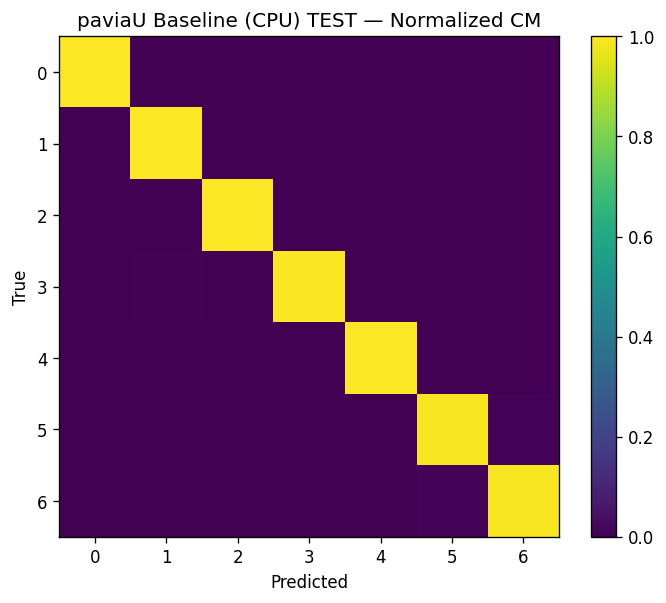

[Baseline/paviaU] Params=307,479 | Size=1.19 MB | Latency=8.57 ms/sample

------------------------------------------------------------
[PTQ] paviaU
------------------------------------------------------------
[make_loaders_3d] train=20410 val=7866 test=7867 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[PTQ] building INT8 (dynamic) Linear-only model on CPU ...
[PTQ] quantized modules ready.
[latency] Measuring on cpu (paviaU PTQ-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 652.09 ms for 128 samples
  [batch 02] 463.27 ms for 128 samples
  [batch 03] 755.72 ms for 128 samples
  [batch 04] 686.18 ms for 128 samples
  [batch 05] 788.33 ms for 128 samples
  [batch 06] 708.55 ms for 128 samples
  [batch 07] 646.09 ms for 128 samples
  [batch 08] 517.17 ms for 128 samples
  [batch 09] 574.11 ms for 128 samples
  [batch 10] 560.09 ms for 128 samples
[latency] avg = 4.96 ms/sample over 1280

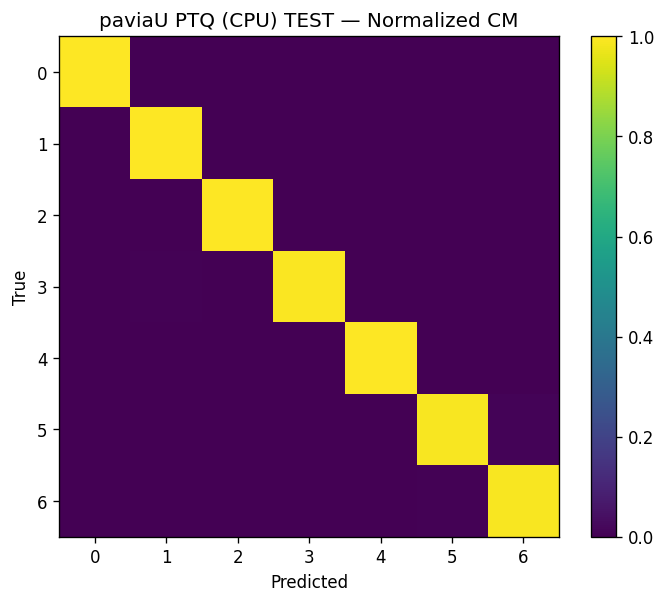

[PTQ/paviaU] Params=21,904 | Size=0.39 MB | Latency=4.96 ms/sample

------------------------------------------------------------
[LowRank] paviaU
------------------------------------------------------------
[make_loaders_3d] train=20410 val=7866 test=7867 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[LowRank] building low-rank model (rank_frac=0.5, min_rank=8) on CPU ...
[LowRank] replacing Linear(32->128) with rank=16
[LowRank] replacing Linear(128->128) with rank=64
[LowRank] classifier kept full-rank
[latency] Measuring on cpu (paviaU LowRank-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 710.80 ms for 128 samples
  [batch 02] 494.28 ms for 128 samples
  [batch 03] 506.42 ms for 128 samples
  [batch 04] 461.31 ms for 128 samples
  [batch 05] 553.31 ms for 128 samples
  [batch 06] 545.22 ms for 128 samples
  [batch 07] 524.29 ms for 128 samples
  [batch 08] 554.72 ms for 128 sample

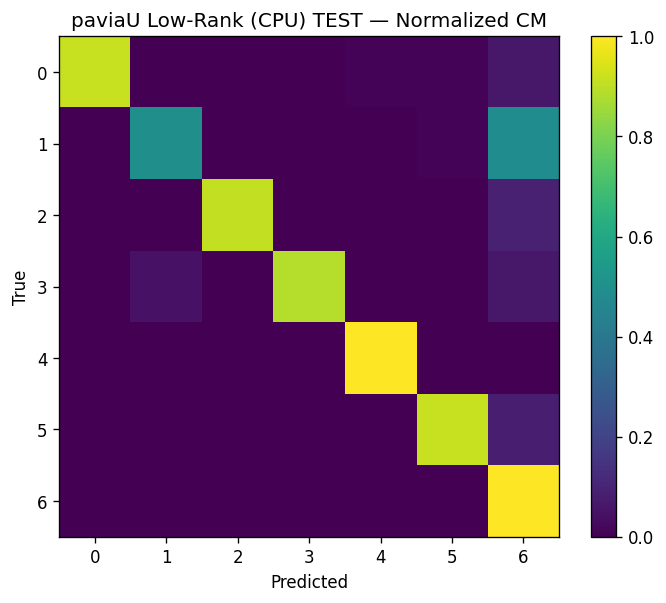

[LowRank/paviaU] Params=305,943 | Size=1.18 MB | Latency=4.08 ms/sample
[saved] D:\Hyperspectral Image Classification\paviaU\comparisons\inbase_baseline_vs_ptq_vs_lowrank.csv


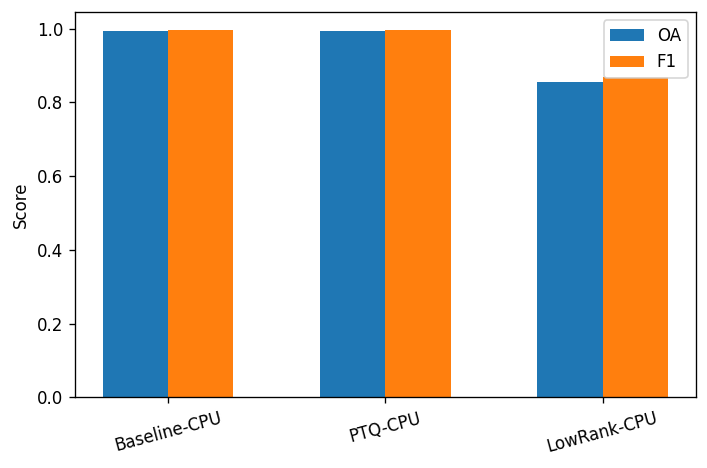

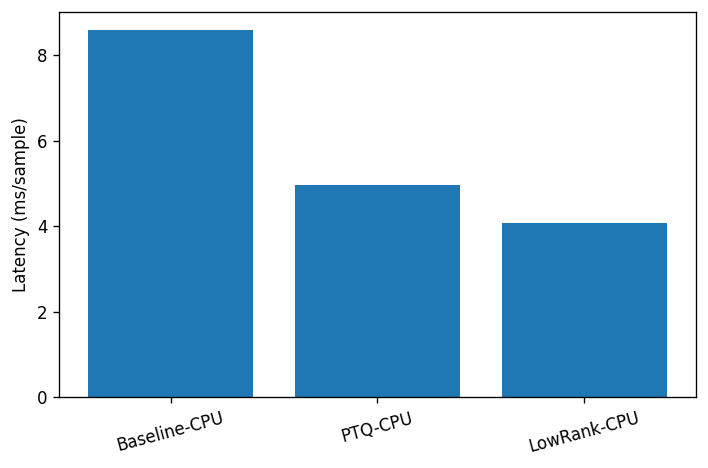


=== In-base comparison for paviaC (CPU, Baseline vs PTQ vs Low-Rank) ===

------------------------------------------------------------
[Baseline CPU] paviaC
------------------------------------------------------------
[make_loaders_3d] train=23613 val=7871 test=7871 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[latency] Measuring on cpu (paviaC Baseline-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 672.90 ms for 128 samples
  [batch 02] 532.67 ms for 128 samples
  [batch 03] 588.31 ms for 128 samples
  [batch 04] 484.50 ms for 128 samples
  [batch 05] 586.97 ms for 128 samples
  [batch 06] 413.63 ms for 128 samples
  [batch 07] 448.87 ms for 128 samples
  [batch 08] 527.46 ms for 128 samples
  [batch 09] 414.77 ms for 128 samples
  [batch 10] 558.92 ms for 128 samples
[latency] avg = 4.09 ms/sample over 1280 samples
[paviaC Baseline (CPU) TEST] OA=0.9968  AA=0.9951  F1=0.9962  Kapp

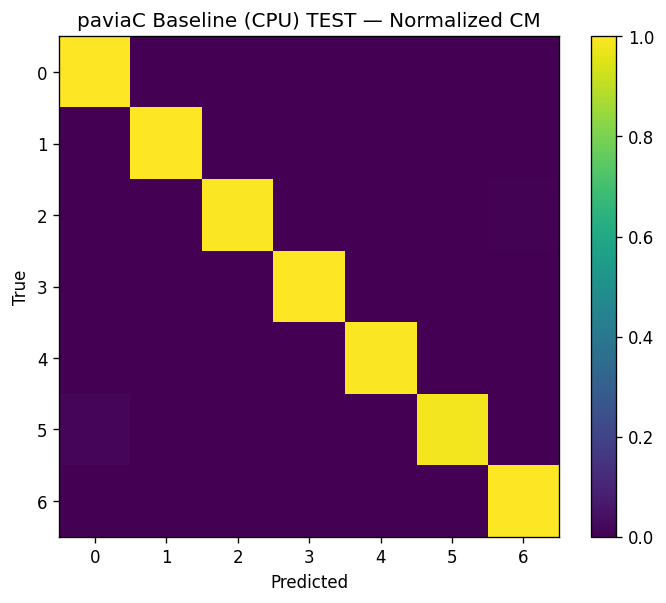

[Baseline/paviaC] Params=307,479 | Size=1.19 MB | Latency=4.09 ms/sample

------------------------------------------------------------
[PTQ] paviaC
------------------------------------------------------------
[make_loaders_3d] train=23613 val=7871 test=7871 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[PTQ] building INT8 (dynamic) Linear-only model on CPU ...
[PTQ] quantized modules ready.
[latency] Measuring on cpu (paviaC PTQ-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 551.47 ms for 128 samples
  [batch 02] 561.98 ms for 128 samples
  [batch 03] 476.16 ms for 128 samples
  [batch 04] 506.06 ms for 128 samples
  [batch 05] 605.24 ms for 128 samples
  [batch 06] 537.07 ms for 128 samples
  [batch 07] 517.60 ms for 128 samples
  [batch 08] 533.97 ms for 128 samples
  [batch 09] 493.72 ms for 128 samples
  [batch 10] 534.58 ms for 128 samples
[latency] avg = 4.15 ms/sample over 1280

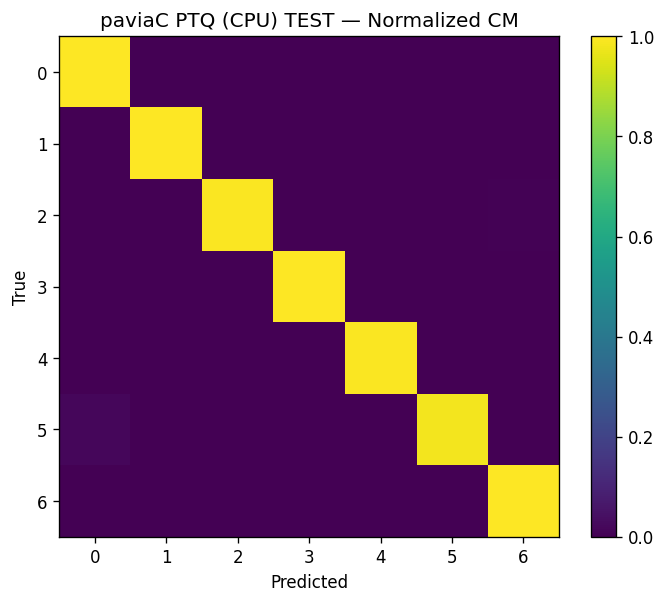

[PTQ/paviaC] Params=21,904 | Size=0.39 MB | Latency=4.15 ms/sample

------------------------------------------------------------
[LowRank] paviaC
------------------------------------------------------------
[make_loaders_3d] train=23613 val=7871 test=7871 | patch=(9, 9, 102) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 102, 9, 9) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[LowRank] building low-rank model (rank_frac=0.5, min_rank=8) on CPU ...
[LowRank] replacing Linear(32->128) with rank=16
[LowRank] replacing Linear(128->128) with rank=64
[LowRank] classifier kept full-rank
[latency] Measuring on cpu (paviaC LowRank-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 692.07 ms for 128 samples
  [batch 02] 582.96 ms for 128 samples
  [batch 03] 548.05 ms for 128 samples
  [batch 04] 615.56 ms for 128 samples
  [batch 05] 655.86 ms for 128 samples
  [batch 06] 697.53 ms for 128 samples
  [batch 07] 694.69 ms for 128 samples
  [batch 08] 700.30 ms for 128 sample

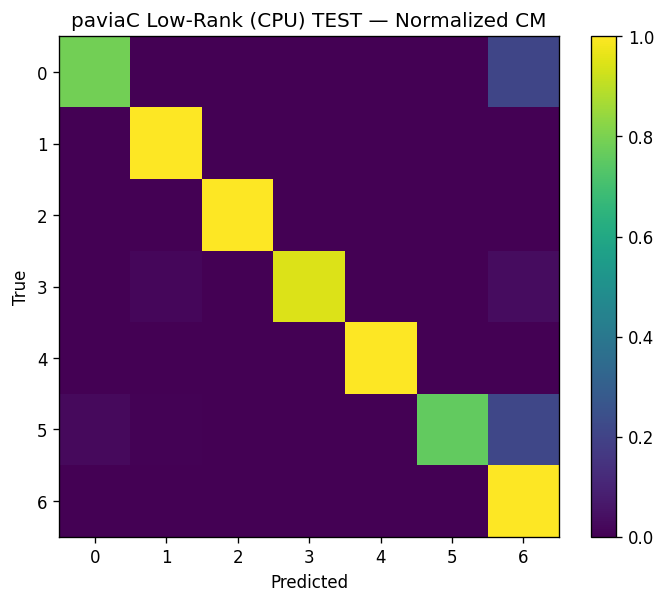

[LowRank/paviaC] Params=305,943 | Size=1.18 MB | Latency=5.01 ms/sample
[saved] D:\Hyperspectral Image Classification\paviaC\comparisons\inbase_baseline_vs_ptq_vs_lowrank.csv


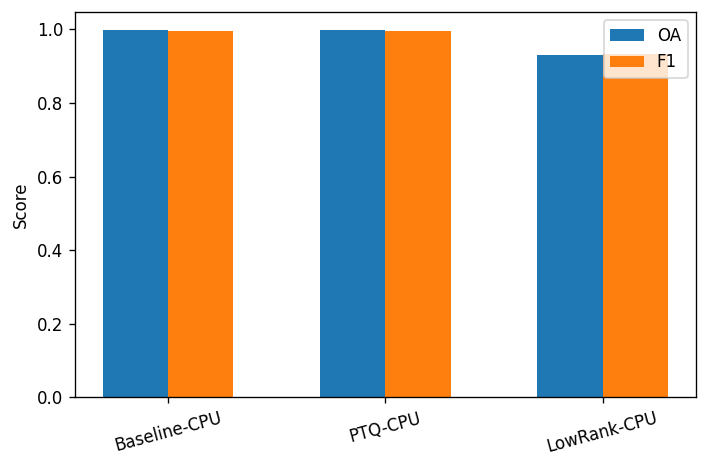

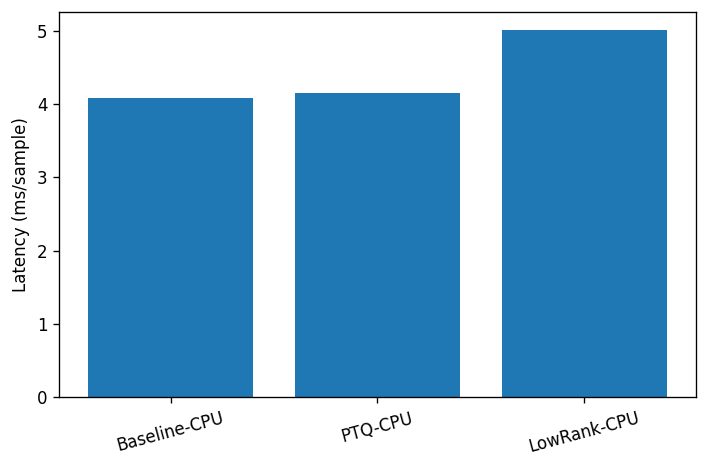

In [19]:
df_u, in_u = inbase_compare_table("paviaU", PREP["paviaU"], RESULTS_DIR, rank_frac=0.5)
df_c, in_c = inbase_compare_table("paviaC", PREP["paviaC"], RESULTS_DIR, rank_frac=0.5)


=== In-base comparison for loukia (CPU, Baseline vs PTQ vs Low-Rank) ===

------------------------------------------------------------
[Baseline CPU] loukia
------------------------------------------------------------
[make_loaders_3d] train=8101 val=2701 test=2701 | patch=(7, 7, 176) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 176, 7, 7) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[latency] Measuring on cpu (loukia Baseline-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 543.24 ms for 128 samples
  [batch 02] 530.30 ms for 128 samples
  [batch 03] 580.99 ms for 128 samples
  [batch 04] 541.64 ms for 128 samples
  [batch 05] 546.78 ms for 128 samples
  [batch 06] 666.80 ms for 128 samples
  [batch 07] 606.62 ms for 128 samples
  [batch 08] 486.71 ms for 128 samples
  [batch 09] 612.54 ms for 128 samples
  [batch 10] 595.98 ms for 128 samples
[latency] avg = 4.46 ms/sample over 1280 samples
[loukia Baseline (CPU) TEST] OA=0.8230  AA=0.8065  F1=0.8000  Kappa

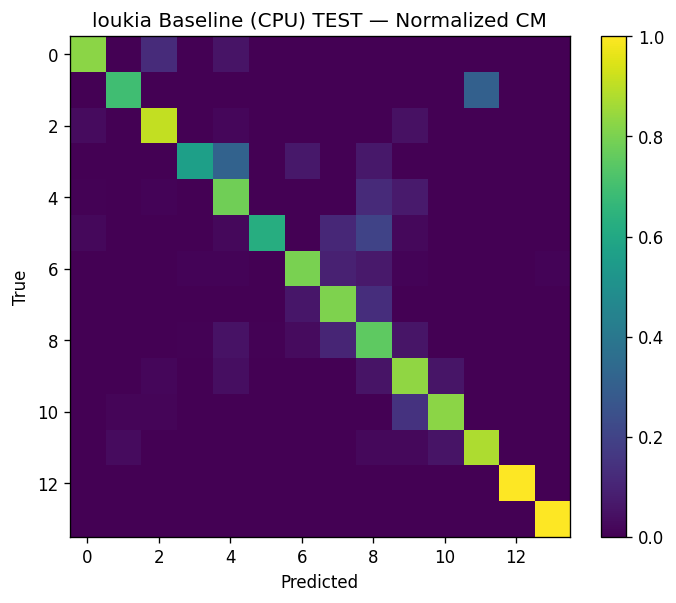

[Baseline/loukia] Params=308,382 | Size=1.19 MB | Latency=4.46 ms/sample

------------------------------------------------------------
[PTQ] loukia
------------------------------------------------------------
[make_loaders_3d] train=8101 val=2701 test=2701 | patch=(7, 7, 176) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 176, 7, 7) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[PTQ] building INT8 (dynamic) Linear-only model on CPU ...
[PTQ] quantized modules ready.
[latency] Measuring on cpu (loukia PTQ-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 557.14 ms for 128 samples
  [batch 02] 660.35 ms for 128 samples
  [batch 03] 719.57 ms for 128 samples
  [batch 04] 737.06 ms for 128 samples
  [batch 05] 789.75 ms for 128 samples
  [batch 06] 800.08 ms for 128 samples
  [batch 07] 744.82 ms for 128 samples
  [batch 08] 754.49 ms for 128 samples
  [batch 09] 815.53 ms for 128 samples
  [batch 10] 575.26 ms for 128 samples
[latency] avg = 5.59 ms/sample over 1280 

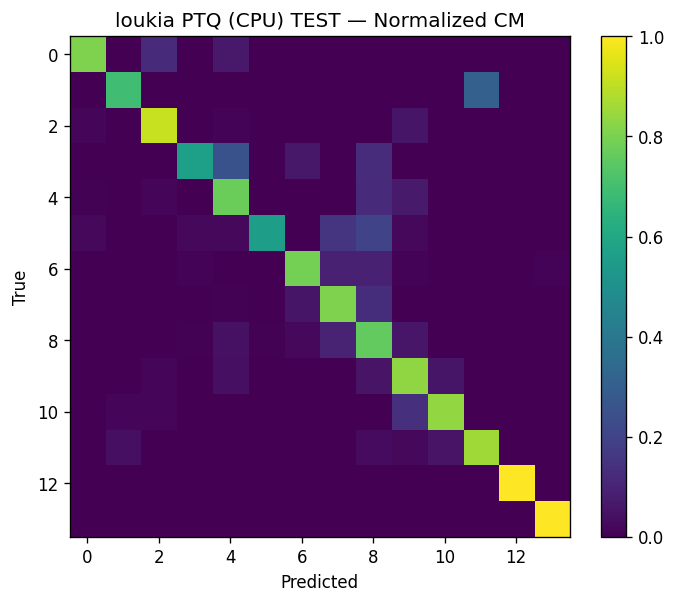

[PTQ/loukia] Params=21,904 | Size=0.39 MB | Latency=5.59 ms/sample

------------------------------------------------------------
[LowRank] loukia
------------------------------------------------------------
[make_loaders_3d] train=8101 val=2701 test=2701 | patch=(7, 7, 176) (k,k,B)
[make_loaders_3d] sample -> xb=(128, 1, 176, 7, 7) yb=(128,) (expect xb=(B,1,BANDS,k,k))
[LowRank] building low-rank model (rank_frac=0.5, min_rank=8) on CPU ...
[LowRank] replacing Linear(32->128) with rank=16
[LowRank] replacing Linear(128->128) with rank=64
[LowRank] replacing Linear(128->14) with rank=8
[latency] Measuring on cpu (loukia LowRank-CPU) ...
[latency] warmup: 3 batches
[latency] timing: 10 batches
  [batch 01] 831.23 ms for 128 samples
  [batch 02] 802.95 ms for 128 samples
  [batch 03] 830.53 ms for 128 samples
  [batch 04] 799.16 ms for 128 samples
  [batch 05] 739.42 ms for 128 samples
  [batch 06] 719.27 ms for 128 samples
  [batch 07] 727.63 ms for 128 samples
  [batch 08] 823.10 ms for

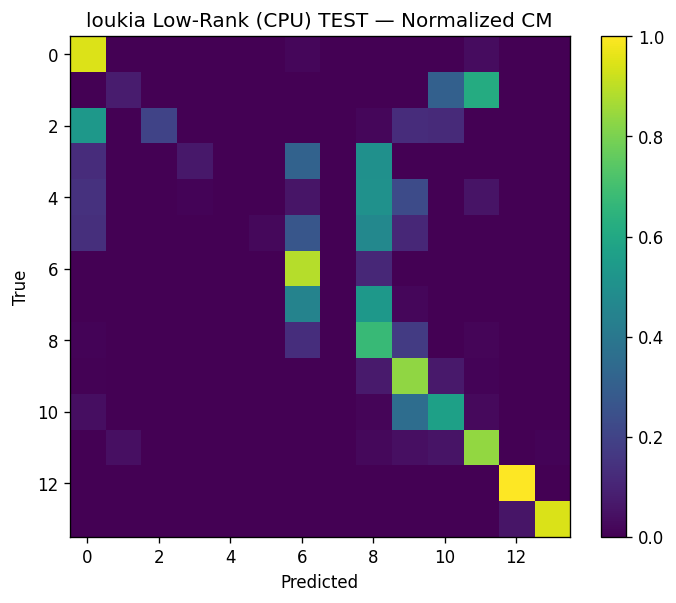

[LowRank/loukia] Params=306,190 | Size=1.19 MB | Latency=6.03 ms/sample
[saved] D:\Hyperspectral Image Classification\loukia\comparisons\inbase_baseline_vs_ptq_vs_lowrank.csv


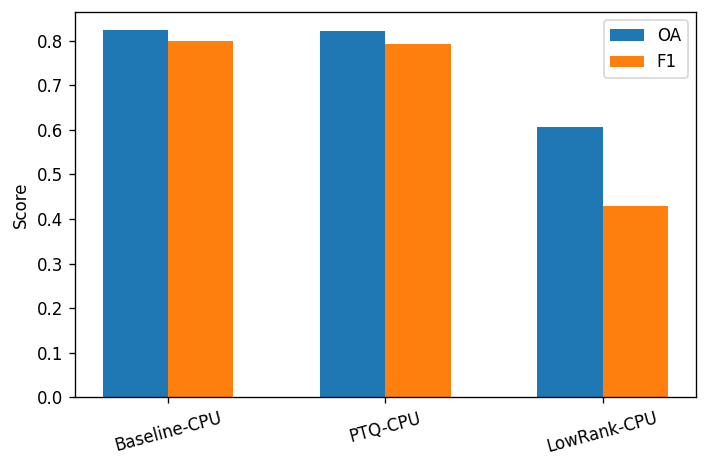

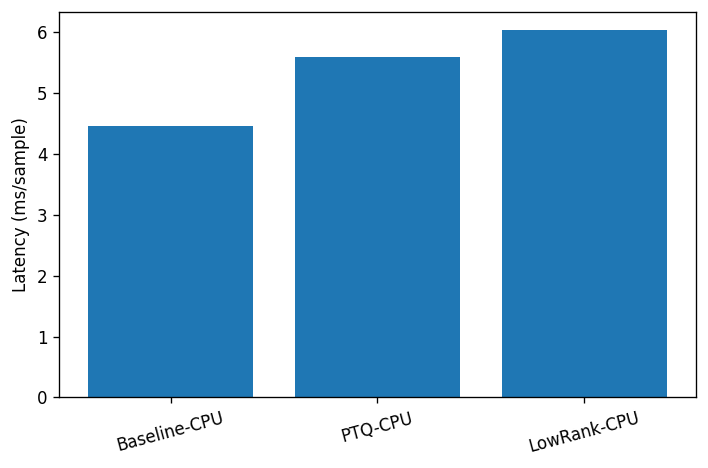

In [20]:
df_l, in_l = inbase_compare_table("loukia", PREP["loukia"], RESULTS_DIR, rank_frac=0.5)

In [34]:
import os
import pandas as pd

def across_summary(in_u, in_c, in_l, df_cross, round_to=4):
    rows = []
    for name, res in [("PaviaU", in_u), ("PaviaC", in_c), ("Loukia", in_l)]:
        for v in ["baseline","ptq","lowrank"]:
            rows.append({
                "Dataset": name,
                "Variant": v.upper(),
                "OA": round(res[v]["OA"], round_to),
                "AA": round(res[v]["AA"], round_to),
                "F1": round(res[v]["F1"], round_to),
                "Kappa": round(res[v]["Kappa"], round_to),
                "Precision": round(res[v]["Precision"], round_to),
                "Recall": round(res[v]["Recall"], round_to),
                "Params": res[v].get("Params", None),
                "ModelMB": res[v].get("ModelMB", None),
                "Latency_ms_per_sample": res[v].get("Latency_ms_per_sample", None)
            })
    df_inbase_all = pd.DataFrame(rows)

    # save CSVs
    out_dir = os.path.join(RESULTS_DIR, "summary")
    os.makedirs(RESULT_DIR, exist_ok=True)
    df_inbase_all.to_csv(os.path.join(out_dir, "inbase_summary.csv"), index=False)
    df_cross.to_csv(os.path.join(out_dir, "cross_summary.csv"), index=False)
    print(f"[saved]\n- {os.path.join(out_dir, 'inbase_summary.csv')}\n- {os.path.join(out_dir, 'cross_summary.csv')}")

    # pretty table display in Jupyter
    return df_inbase_all.style.set_table_styles(
        [{'selector':'','props':'border:1px solid #999;'}]
    ).set_properties(**{'border':'1px solid #999','padding':'4px'}).set_caption("Across-datasets (in-base) summary")

# ---- Usage in Jupyter ----
df_across = across_summary(in_u, in_c, in_l, df_cross)
display(df_across)

[saved]
- D:\Hyperspectral Image Classification\summary\inbase_summary.csv
- D:\Hyperspectral Image Classification\summary\cross_summary.csv


,Dataset,Variant,OA,AA,F1,Kappa,Precision,Recall,Params,ModelMB,Latency_ms_per_sample
0,PaviaU,BASELINE,0.994300,0.996100,0.995200,0.992000,0.994400,0.996100,307479,1.189872,8.572589
1,PaviaU,PTQ,0.994300,0.996100,0.995100,0.992000,0.994000,0.996100,21904,0.389432,4.962190
2,PaviaU,LOWRANK,0.855700,0.874200,0.870000,0.802100,0.916400,0.874200,305943,1.184739,4.077527
3,PaviaC,BASELINE,0.996800,0.995100,0.996200,0.996200,0.997200,0.995100,307479,1.189872,4.085158
4,PaviaC,PTQ,0.997000,0.995100,0.996200,0.996300,0.997300,0.995100,21904,0.389432,4.154568
5,PaviaC,LOWRANK,0.929400,0.926700,0.932700,0.914700,0.952900,0.926700,305943,1.184739,5.006516
6,Loukia,BASELINE,0.823000,0.806500,0.800000,0.791800,0.800100,0.806500,308382,1.193290,4.462185
7,Loukia,PTQ,0.822300,0.799800,0.792900,0.790700,0.794800,0.799800,21904,0.390286,5.589105
8,Loukia,LOWRANK,0.605700,0.504000,0.430300,0.527900,0.518800,0.504000,306190,1.185957,6.030386


In [35]:
df_baseline, tbl_baseline = build_baseline_best_table(DATASETS, RESULTS_DIR, round_to=4, save=True)
display(tbl_baseline)

[saved] D:\Hyperspectral Image Classification\summary\baseline_best_summary.csv


,Dataset,Device,Batch,Params,ModelMB,Latency_ms,OA,AA,F1,Kappa,Precision,Recall
0,paviaU,cuda,128,307479,1.173300,64.564000,0.994300,0.996100,0.995200,0.992000,0.994400,0.996100
1,paviaC,cuda,128,307479,1.173300,64.570000,0.996800,0.995100,0.996200,0.996200,0.997200,0.995100
2,loukia,cuda,128,308382,1.176800,89.252000,0.823000,0.806600,0.799900,0.791800,0.799800,0.806600


# Comparison Table

In [36]:

import os
import json
import pandas as pd

# Assumes you already defined RESULTS_DIR and in_u, in_c, in_l, df_cross earlier.
GPU_CSV = r"D:\Hyperspectral Image Classification\summary\baseline_best_summary.csv"

def _sround(v, nd=4):
    try:
        return round(float(v), nd)
    except Exception:
        return None

def _pretty(name: str) -> str:
    s = str(name).strip().lower()
    return {"paviau":"PaviaU","paviac":"PaviaC","loukia":"Loukia"}.get(s, str(name))

def across_summary(in_u, in_c, in_l, df_cross, round_to=4):
    rows = []

    # 1) rows from your dicts (baseline / ptq / lowrank)
    for name, res in (("PaviaU", in_u), ("PaviaC", in_c), ("Loukia", in_l)):
        for v in ("baseline","ptq","lowrank"):
            vdict = res.get(v, {})
            rows.append({
                "Dataset": name,
                "Variant": v.upper(),
                "OA": _sround(vdict.get("OA"), round_to),
                "AA": _sround(vdict.get("AA"), round_to),
                "F1": _sround(vdict.get("F1"), round_to),
                "Kappa": _sround(vdict.get("Kappa"), round_to),
                "Precision": _sround(vdict.get("Precision"), round_to),
                "Recall": _sround(vdict.get("Recall"), round_to),
                "Params": vdict.get("Params"),
                "ModelMB": _sround(vdict.get("ModelMB"), round_to),
                "Latency_ms_per_sample": _sround(vdict.get("Latency_ms_per_sample"), round_to),
            })

    # 2) append Baseline: 3D-CNN (GPU) from the CSV you specified
    if os.path.isfile(GPU_CSV):
        df_gpu = pd.read_csv(GPU_CSV)
        for _, g in df_gpu.iterrows():
            ds = _pretty(g.get("Dataset"))
            # per-sample latency from per-batch
            try:
                batch = float(g.get("Batch", 1) or 1)
            except Exception:
                batch = 1.0
            try:
                lat_ms = float(g["Latency_ms"]) if pd.notna(g.get("Latency_ms")) else None
            except Exception:
                lat_ms = None
            per_sample = (lat_ms / batch) if (lat_ms is not None and batch > 0) else None

            rows.append({
                "Dataset": ds,
                "Variant": "3D-CNN (GPU)",
                "OA": _sround(g.get("OA"), round_to),
                "AA": _sround(g.get("AA"), round_to),
                "F1": _sround(g.get("F1"), round_to),
                "Kappa": _sround(g.get("Kappa"), round_to),
                "Precision": _sround(g.get("Precision"), round_to),
                "Recall": _sround(g.get("Recall"), round_to),
                "Params": g.get("Params"),
                "ModelMB": _sround(g.get("ModelMB"), round_to),
                "Latency_ms_per_sample": _sround(per_sample, round_to),
            })

    # 3) build/save/display
    df = pd.DataFrame(rows, columns=[
        "Dataset","Variant","OA","AA","F1","Kappa","Precision","Recall",
        "Params","ModelMB","Latency_ms_per_sample"
    ])

    out_dir = os.path.join(RESULTS_DIR, "summary")
    os.makedirs(RESULT_DIR, exist_ok=True)
    df.to_csv(os.path.join(out_dir, "inbase_summary.csv"), index=False)

    # save df_cross safely (DataFrame or Styler)
    cross_csv = os.path.join(out_dir, "cross_summary.csv")
    if isinstance(df_cross, pd.io.formats.style.Styler):
        df_cross = df_cross.data
    if isinstance(df_cross, pd.DataFrame):
        df_cross.to_csv(cross_csv, index=False)
    else:
        pd.DataFrame().to_csv(cross_csv, index=False)

    return df.style.set_table_styles(
        [{'selector':'','props':'border:1px solid #999;'}]
    ).set_properties(**{'border':'1px solid #999','padding':'4px'}).set_caption(
        "Across-datasets (in-base) summary — incl. Baseline: 3D-CNN (GPU) from CSV"
    )

# ---- Call it in a NEW cell after running the cell above ----
df_across = across_summary(in_u, in_c, in_l, df_cross)
display(df_across)

,Dataset,Variant,OA,AA,F1,Kappa,Precision,Recall,Params,ModelMB,Latency_ms_per_sample
0,PaviaU,BASELINE,0.994300,0.996100,0.995200,0.992000,0.994400,0.996100,307479,1.189900,8.572600
1,PaviaU,PTQ,0.994300,0.996100,0.995100,0.992000,0.994000,0.996100,21904,0.389400,4.962200
2,PaviaU,LOWRANK,0.855700,0.874200,0.870000,0.802100,0.916400,0.874200,305943,1.184700,4.077500
3,PaviaC,BASELINE,0.996800,0.995100,0.996200,0.996200,0.997200,0.995100,307479,1.189900,4.085200
4,PaviaC,PTQ,0.997000,0.995100,0.996200,0.996300,0.997300,0.995100,21904,0.389400,4.154600
5,PaviaC,LOWRANK,0.929400,0.926700,0.932700,0.914700,0.952900,0.926700,305943,1.184700,5.006500
6,Loukia,BASELINE,0.823000,0.806500,0.800000,0.791800,0.800100,0.806500,308382,1.193300,4.462200
7,Loukia,PTQ,0.822300,0.799800,0.792900,0.790700,0.794800,0.799800,21904,0.390300,5.589100
8,Loukia,LOWRANK,0.605700,0.504000,0.430300,0.527900,0.518800,0.504000,306190,1.186000,6.030400
9,PaviaU,3D-CNN (GPU),0.994300,0.996100,0.995200,0.992000,0.994400,0.996100,307479,1.173300,0.504400


# === Comparison graphs 3D-CNN (GPU) vs baseline (CPU) vs PTQ vs Low Rank for F1 & OA per dataset ===

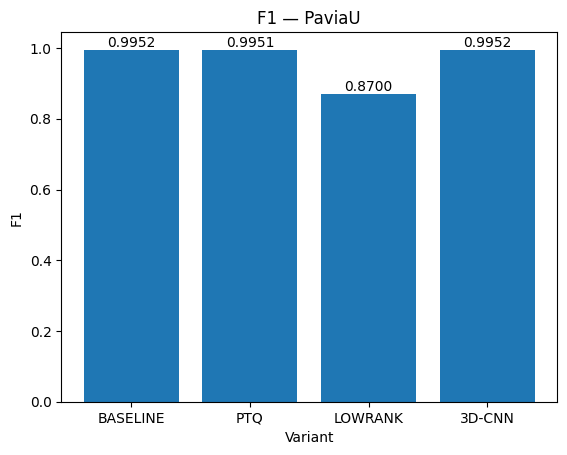

[saved] D:\Result\summary\graphs\PaviaU_F1_comparison_with_3dcnn.png


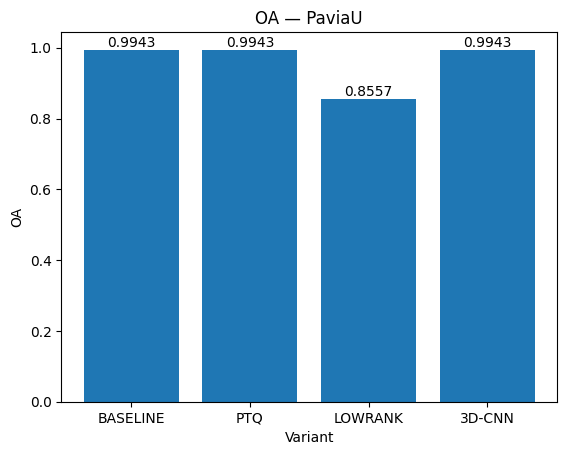

[saved] D:\Result\summary\graphs\PaviaU_OA_comparison_with_3dcnn.png


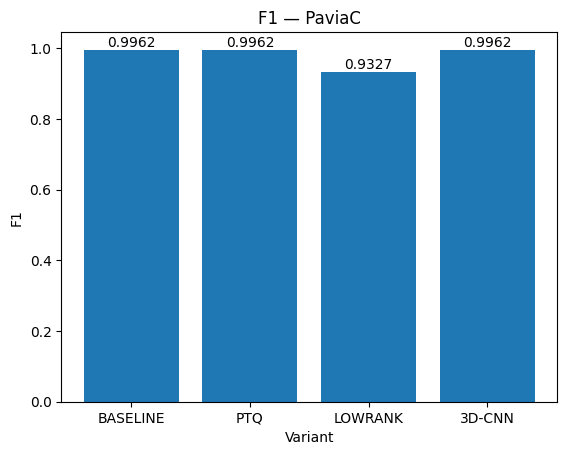

[saved] D:\Result\summary\graphs\PaviaC_F1_comparison_with_3dcnn.png


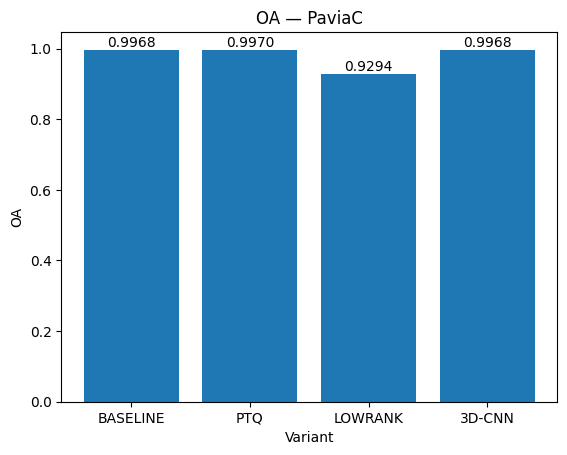

[saved] D:\Result\summary\graphs\PaviaC_OA_comparison_with_3dcnn.png


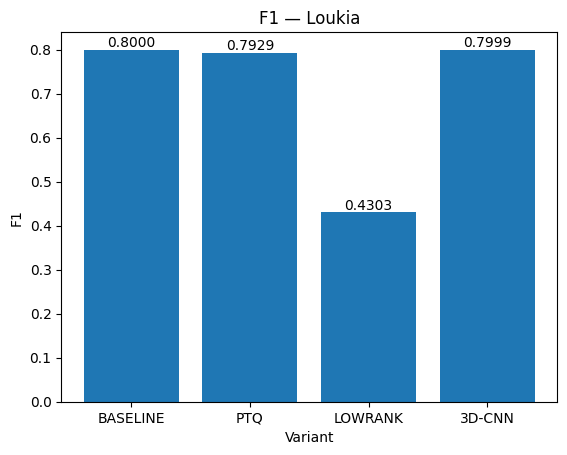

[saved] D:\Result\summary\graphs\Loukia_F1_comparison_with_3dcnn.png


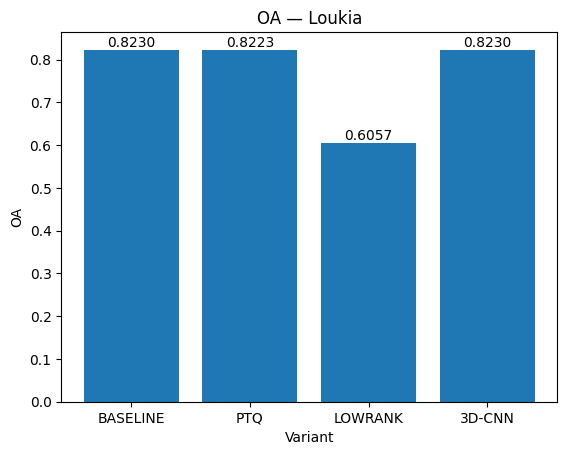

[saved] D:\Result\summary\graphs\Loukia_OA_comparison_with_3dcnn.png


,Dataset,Variant,F1,OA
0,Loukia,3D-CNN,0.7999,0.8230
1,Loukia,BASELINE,0.8000,0.8230
2,Loukia,LOWRANK,0.4303,0.6057
3,Loukia,PTQ,0.7929,0.8223
4,PaviaC,3D-CNN,0.9962,0.9968
5,PaviaC,BASELINE,0.9962,0.9968
6,PaviaC,LOWRANK,0.9327,0.9294
7,PaviaC,PTQ,0.9962,0.9970
8,PaviaU,3D-CNN,0.9952,0.9943
9,PaviaU,BASELINE,0.9952,0.9943


In [40]:
# === Comparison graphs incl. 3D-CNN (GPU) for F1 & OA per dataset ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re

# Resolve results dir (supports either variable name)
RESULT_DIR = globals().get("RESULT_DIR") or globals().get("RESULTS_DIR") or r"D:\Result"
summary_dir = Path(RESULT_DIR) / "summary"
summary_dir.mkdir(parents=True, exist_ok=True)
csv_path = summary_dir / "inbase_summary.csv"

# 1) Load summary (prefer in-memory df_across; else read CSV)
if "df_across" in globals():
    base_df = df_across.data if isinstance(df_across, pd.io.formats.style.Styler) else df_across.copy()
else:
    base_df = pd.read_csv(csv_path)

# 2) Normalize variant names to: BASELINE, PTQ, LOWRANK, 3D-CNN
def _norm_variant(s: str) -> str:
    s = str(s)
    key = re.sub(r"[^A-Za-z0-9]", "", s).upper()   # strip spaces, dashes, ()
    if "BASELINE" in key:      return "BASELINE"
    if "PTW" in key or "PTQ" in key:  return "PTQ"
    if "LOWRANK" in key:       return "LOWRANK"
    if "3DCNN" in key:         return "3D-CNN"
    return s  # leave unknowns as-is

df_plot = base_df.copy()
df_plot["Variant"] = df_plot["Variant"].map(_norm_variant)

# Keep only the four we care about
wanted = ["BASELINE","PTQ","LOWRANK","3D-CNN"]
df_plot = df_plot[df_plot["Variant"].isin(wanted)].copy()

# Ensure numeric F1 / OA
for col in ["F1","OA"]:
    df_plot[col] = pd.to_numeric(df_plot[col], errors="coerce")

# Output folder for graphs
graphs_dir = summary_dir / "graphs"
graphs_dir.mkdir(parents=True, exist_ok=True)

datasets = ["PaviaU","PaviaC","Loukia"]
order = pd.CategoricalDtype(categories=wanted, ordered=True)

for ds in datasets:
    sub = df_plot[df_plot["Dataset"].str.lower() == ds.lower()].copy()
    if sub.empty:
        print(f"[warn] No rows for {ds}; skipping.")
        continue
    sub["Variant"] = sub["Variant"].astype(order)
    sub = sub.sort_values("Variant")

    for metric in ["F1","OA"]:
        if metric not in sub or sub[metric].dropna().empty:
            print(f"[warn] No '{metric}' values for {ds}; skipping.")
            continue

        # Bar chart with 4 variants (includes 3D-CNN)
        plt.figure()
        plt.bar(sub["Variant"].astype(str), sub[metric].astype(float))
        plt.title(f"{metric} — {ds}")
        plt.xlabel("Variant")
        plt.ylabel(metric)

        # annotate bars
        for i, v in enumerate(sub[metric].astype(float).values):
            if pd.notna(v):
                plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

        out_png = graphs_dir / f"{ds}_{metric}_comparison_with_3dcnn.png"
        plt.savefig(out_png, dpi=120, bbox_inches="tight")
        plt.show()
        print(f"[saved] {out_png}")

# Optional: show compact pivot of what was plotted
pivot = df_plot.pivot_table(index=["Dataset","Variant"], values=["F1","OA"], aggfunc="first").reset_index()
display(pivot)
